In [124]:
# changes 

# weekly (index) - done
# public holiday - non of the invoice-date falls in public holiday
# bangkok - done
# linear regression

# why day in week important 
# model limitation + solution


In [125]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install --upgrade category_encoders
# !pip install squarify

In [126]:
# public holiday filter
# sample date format: 2022-08-07
from datetime import datetime

#2021
holiday_21 = ['2021-09-24',
'2021-10-13',
'2021-10-22',
'2021-12-05',
'2021-12-06',
'2021-12-10',
'2021-12-31']

#2022
holiday_22 = [
'2022-01-01',
'2022-01-03',
'2022-02-16',
'2022-04-06',
'2022-04-13',
'2022-04-14',
'2022-04-15',
'2022-05-04',
'2022-05-13',
'2022-05-16',
'2022-06-03',
'2022-07-13',
'2022-07-14',
'2022-07-28',
'2022-08-12',
'2022-10-13',
'2022-10-23',
'2022-10-24',
'2022-12-05',
'2022-12-10',
'2022-12-12']

holidays = holiday_21 + holiday_22
holidays

#final holidays
finalHolidays = []
#convert to datetime
for d in holidays:
    finalHolidays.append(datetime.strptime(d, '%Y-%m-%d').date())

reference: https://www.kaggle.com/code/ekrembayar/store-item-demand-forecasting-with-lgbm/notebook

In [127]:
#data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

#preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

#model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#encoding
import category_encoders as ce

#LSTM
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,LSTM,GRU,Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [128]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Data Import

In [129]:
df = pd.read_csv('osp_cube_vansales_raw copy.csv', sep = ',')

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14355230 entries, 0 to 14355229
Data columns (total 22 columns):
 #   Column           Dtype  
---  ------           -----  
 0   customercode     object 
 1   customername     object 
 2   invoicenumber    object 
 3   invoice_date     object 
 4   productcode      int64  
 5   productnameth    object 
 6   baseqty          int64  
 7   grossamount      float64
 8   netamount        float64
 9   groupnamelevel1  object 
 10  groupnamelevel2  object 
 11  groupnamelevel3  object 
 12  dc_code          object 
 13  dc_name          object 
 14  regionname       object 
 15  customertype     object 
 16  districtname     object 
 17  provincename     object 
 18  salesmancode     object 
 19  latitude         object 
 20  longitude        object 
 21  ProvinceNameEng  object 
dtypes: float64(2), int64(2), object(18)
memory usage: 2.4+ GB


In [131]:
df.head(3)

,customercode,customername,invoicenumber,invoice_date,productcode,productnameth,baseqty,grossamount,netamount,groupnamelevel1,...,dc_code,dc_name,regionname,customertype,districtname,provincename,salesmancode,latitude,longitude,ProvinceNameEng
0,XYZ001687,ร้านแม่กำไร,HSV43C04358,2022-08-07,10000600,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,50,490.98,485.98,M-150,...,XYZ,เจทีเอ็ม อิมปอร์ต เอ๊กซ์ปอร์ต,LNO,โชว์ห่วยเล็ก (Community),อ.อุ้มผาง,จ.ตาก,XYZV03,16.067354,98.766893,Tak
1,OWK002779,ร้านเบญไข่ไก่-ข้าวสาร(หนองพลับ,HSX65C01536,2022-03-09,10000604,ซี-วิท ทับทิม 140 มล. 1x3x10,10,126.28,124.62,C-VITT,...,OWK,อ.วัฒนา (2018),CW,โชว์ห่วยเล็ก (Community),อ.หัวหิน,จ.ประจวบคีรีขันธ์,OWKO01,12.588834,99.735069,Prachuap Khiri Khan
2,PYD000698,???้าน อารีย์,HSU21C00865,2022-03-09,10000566,เอ็มเกลือแร่ 250มล เหลือง 1x24,6,47.73,46.73,M-ELECTROLYTE,...,PYD,ภิญโญ ดิสทริบิวชั่น,USO,โชว์ห่วยเล็ก (Community),อ.ตะกั่วทุ่ง,จ.พังงา,PYDV01,8.256646,98.281321,Phang-nga


# Preprocessing

## Type Conversion & feature engineering

In [132]:
# date conversion
# df['invoice_date'] = df['invoice_date'].astype('datetime64[ns]')
df['invoice_date'] = pd.to_datetime(df['invoice_date'],format='%Y-%m-%d')

# extract month from date
df['month'] = df['invoice_date'].dt.month
# df['month'] = df['month'].astype('category')

# convert product code to categorical
df['productcode'] = df['productcode'].astype('category')

# day of week
df['day_of_week'] = df['invoice_date'].dt.dayofweek

# quarter
df['quarter'] = df['invoice_date'].dt.quarter

# week of year
df['week_of_year'] = df['invoice_date'].dt.weekofyear

# day
df['day'] = df['invoice_date'].dt.day

# is it weekend
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp = df['invoice_date']    
temp2 = df.invoice_date.apply(applyer)
df['weekend'] = temp2

df.info()

<ipython-input-132-802a433506c3>:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df['invoice_date'].dt.weekofyear


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14355230 entries, 0 to 14355229
Data columns (total 28 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customercode     object        
 1   customername     object        
 2   invoicenumber    object        
 3   invoice_date     datetime64[ns]
 4   productcode      category      
 5   productnameth    object        
 6   baseqty          int64         
 7   grossamount      float64       
 8   netamount        float64       
 9   groupnamelevel1  object        
 10  groupnamelevel2  object        
 11  groupnamelevel3  object        
 12  dc_code          object        
 13  dc_name          object        
 14  regionname       object        
 15  customertype     object        
 16  districtname     object        
 17  provincename     object        
 18  salesmancode     object        
 19  latitude         object        
 20  longitude        object        
 21  ProvinceNameEng  object      

In [133]:
# # mark holiday
# def isHoliday(row):
#     if row in holidays:
#         return 1
#     else:
#         return 0

# temp3 = df.invoice_date.apply(isHoliday)
# df['isHoliday'] = temp3
# df.info()

In [134]:
# # check if holiday is marked

# # holiday_21 = ['2021-09-24',
# # '2021-10-13',
# # '2021-10-22',
# # '2021-12-05',
# # '2021-12-06',
# # '2021-12-10',
# # '2021-12-31']

# # #2022
# # holiday_22 = [
# # '2022-01-01',
# # '2022-01-03',
# # '2022-02-16',
# # '2022-04-06',
# # '2022-04-13',
# # '2022-04-14',
# # '2022-04-15',
# # '2022-05-04',
# # '2022-05-13',
# # '2022-05-16',
# # '2022-06-03',
# # '2022-07-13',
# # '2022-07-14',
# # '2022-07-28',
# # '2022-08-12',
# # '2022-10-13',
# # '2022-10-23',
# # '2022-10-24',
# # '2022-12-05',
# # '2022-12-10',
# # '2022-12-12']

# df.loc[(df['invoice_date'] == '2022-12-10')]

In [135]:
# filter out bkk only
bk_df = df.loc[(df['regionname'] == 'BKK1') | (df['regionname'] == 'BKK2')]
df = bk_df.copy()

In [136]:
df.head(3)

,customercode,customername,invoicenumber,invoice_date,productcode,productnameth,baseqty,grossamount,netamount,groupnamelevel1,...,salesmancode,latitude,longitude,ProvinceNameEng,month,day_of_week,quarter,week_of_year,day,weekend
49,MPS001526,ร้านประสาน,IVZZ22200471,2022-04-02,10000600,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,250,2456.54,2406.54,M-150,...,MPSP01,13.8725,100.600239,Bangkok,4,5,2,13,2,1
58,PCP000941,ร้านบูรภา28,HSP87B07052,2021-11-19,10000512,ลิโพวิตัน-ดี 100มล 1X5X10,10,97.20,97.20,LIPO,...,PCPV01,13.927828,100.563534,Bangkok,11,4,4,46,19,0
63,KIM000554,ร้านเงาะ,IVK362103180,2021-11-19,10000604,ซี-วิท ทับทิม 140 มล. 1x3x10,10,122.50,121.50,C-VITT,...,KIMP03,13.790276,100.497052,Bangkok,11,4,4,46,19,0


In [137]:
df.regionname.unique()

array(['BKK2', 'BKK1'], dtype=object)

In [138]:
minDate = df['invoice_date'].min()
maxDate = df['invoice_date'].max()

print("min date:",minDate)
print("max date:",maxDate)

min date: 2021-09-20 00:00:00
max date: 2022-09-19 00:00:00


In [139]:
# check for null value in each col
df.isnull().mean() * 100

customercode       0.000000
customername       0.000501
invoicenumber      0.000000
invoice_date       0.000000
productcode        0.000000
productnameth      0.000000
baseqty            0.000000
grossamount        0.000000
netamount          0.000000
groupnamelevel1    0.000000
groupnamelevel2    0.000000
groupnamelevel3    0.000000
dc_code            0.000000
dc_name            0.000000
regionname         0.000000
customertype       0.000000
districtname       0.000000
provincename       0.000000
salesmancode       0.002550
latitude           0.073486
longitude          0.071073
ProvinceNameEng    0.000000
month              0.000000
day_of_week        0.000000
quarter            0.000000
week_of_year       0.000000
day                0.000000
weekend            0.000000
dtype: float64

In [140]:
#train set 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2196322 entries, 49 to 14292040
Data columns (total 28 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customercode     object        
 1   customername     object        
 2   invoicenumber    object        
 3   invoice_date     datetime64[ns]
 4   productcode      category      
 5   productnameth    object        
 6   baseqty          int64         
 7   grossamount      float64       
 8   netamount        float64       
 9   groupnamelevel1  object        
 10  groupnamelevel2  object        
 11  groupnamelevel3  object        
 12  dc_code          object        
 13  dc_name          object        
 14  regionname       object        
 15  customertype     object        
 16  districtname     object        
 17  provincename     object        
 18  salesmancode     object        
 19  latitude         object        
 20  longitude        object        
 21  ProvinceNameEng  object      

In [141]:
import datetime
from datetime import timedelta

full_train_start_day = minDate
full_train_end_day = maxDate

# data time range for validation split 
val_end_day = full_train_end_day
val_start_day = val_end_day - datetime.timedelta(days = 7)

# data time range for train
train_start_day = full_train_start_day 
train_end_day = val_end_day - datetime.timedelta(days = 8)

# data time range of test set
test_start_day = val_end_day + datetime.timedelta(days = 1)
test_end_day = test_start_day + datetime.timedelta(days = 7)

print('full_train_start_day',full_train_start_day)
print('full_train_start_day',full_train_end_day)
print('date duration:',(full_train_end_day - full_train_start_day).days, "\n")

print('train_start_day',train_start_day)
print('train_end_day',train_end_day)
print('date duration:',(train_end_day - train_start_day).days, "\n")

print('val_start_day',val_start_day)
print('val_end_day',val_end_day)
print('date duration:',(val_end_day - val_start_day).days, "\n")

print('test_start_day',test_start_day)
print('test_end_day',test_end_day)
print('date duration:',(test_end_day - test_start_day).days, "\n")

full_train_start_day 2021-09-20 00:00:00
full_train_start_day 2022-09-19 00:00:00
date duration: 364 

train_start_day 2021-09-20 00:00:00
train_end_day 2022-09-11 00:00:00
date duration: 356 

val_start_day 2022-09-12 00:00:00
val_end_day 2022-09-19 00:00:00
date duration: 7 

test_start_day 2022-09-20 00:00:00
test_end_day 2022-09-27 00:00:00
date duration: 7 



## Drop Column

In [142]:
def dropCol(df):
    df = df.drop(columns=['latitude','longitude','productcode','dc_name','ProvinceNameEng','grossamount','customername','netamount'])

  # #check and remove duplicate
  # print("total rows in dataframe",len(df))
  # duplicatedRowCount = df.duplicated(subset=None, keep='first').sum()
  # print('removing ', duplicatedRowCount ," rows")
  # print("remaining rows:",len(df) - duplicatedRowCount)
    return df

df_1 = dropCol(df)

In [143]:
#drop rows with 0 values
df_2 = df_1.loc[~((df_1['baseqty'] == 0))]
# check if dropped 
df_2.loc[df_2['baseqty'] == 0] 

,customercode,invoicenumber,invoice_date,productnameth,baseqty,groupnamelevel1,groupnamelevel2,groupnamelevel3,dc_code,regionname,customertype,districtname,provincename,salesmancode,month,day_of_week,quarter,week_of_year,day,weekend


In [144]:
df_2.describe()

,baseqty,month,day_of_week,quarter,week_of_year,day,weekend
count,2.099182e+06,2.099182e+06,2.099182e+06,2.099182e+06,2.099182e+06,2.099182e+06,2.099182e+06
mean,3.052873e+01,6.530351e+00,2.555119e+00,2.507337e+00,2.639511e+01,1.620043e+01,1.794308e-01
std,1.098626e+02,3.361555e+00,1.753585e+00,1.096693e+00,1.455641e+01,8.533676e+00,3.837128e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+01,4.000000e+00,1.000000e+00,2.000000e+00,1.400000e+01,9.000000e+00,0.000000e+00
50%,1.000000e+01,7.000000e+00,3.000000e+00,3.000000e+00,2.700000e+01,1.700000e+01,0.000000e+00
75%,2.000000e+01,9.000000e+00,4.000000e+00,3.000000e+00,3.900000e+01,2.300000e+01,0.000000e+00
max,8.005000e+04,1.200000e+01,6.000000e+00,4.000000e+00,5.200000e+01,3.100000e+01,1.000000e+00


# EDA

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='baseqty', ylabel='Density'>

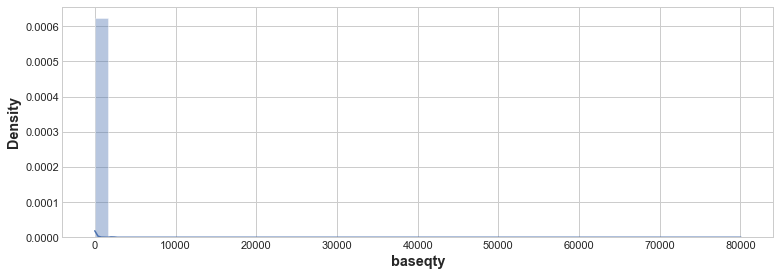

In [145]:
sns.distplot(df_2["baseqty"])

Text(0, 0.5, 'baseqty')

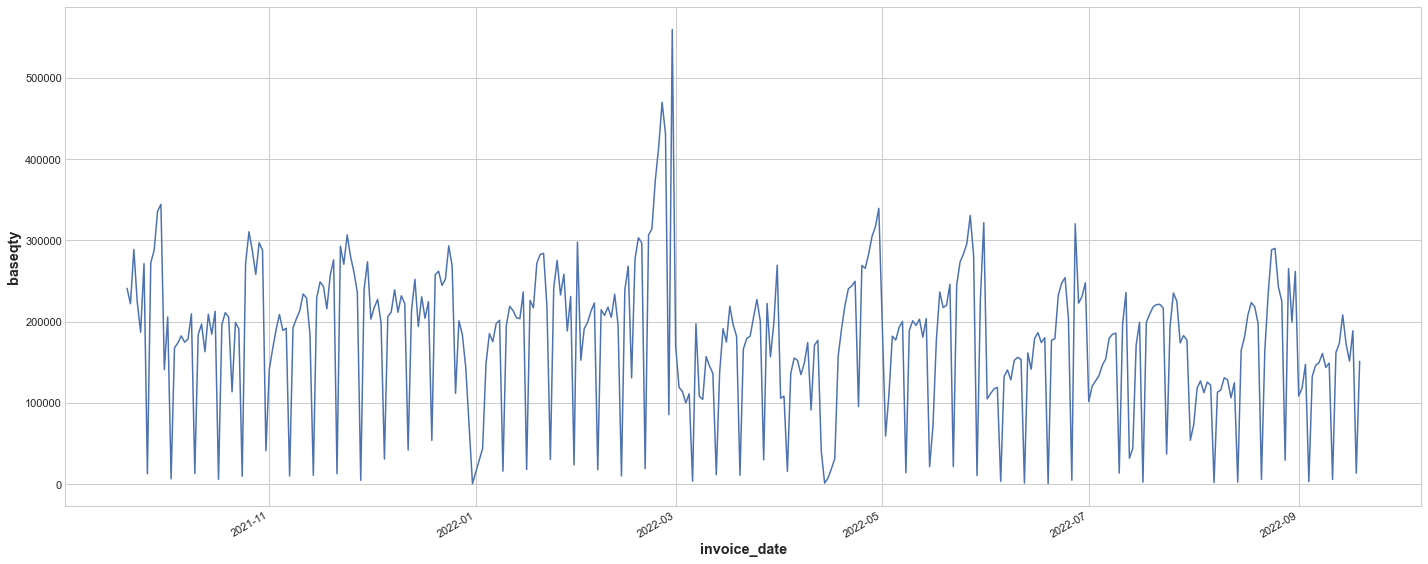

In [146]:
# baseqty by date
df_2.groupby('invoice_date').sum()['baseqty'].plot(figsize = (20,8))
plt.xlabel("invoice_date")
plt.ylabel("baseqty")

Text(0, 0.5, 'baseqty')

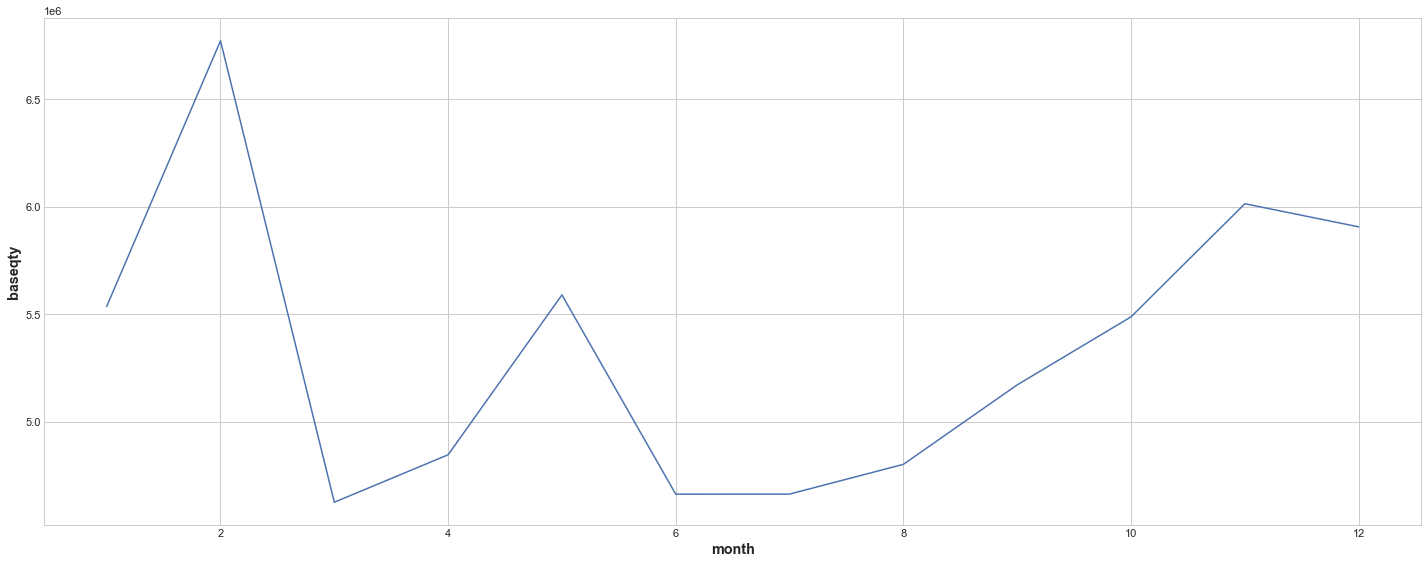

In [147]:
# baseqty by month
df_2.groupby('month').sum()['baseqty'].plot(figsize = (20,8))
plt.xlabel("month")
plt.ylabel("baseqty")

Text(0, 0.5, 'baseqty')

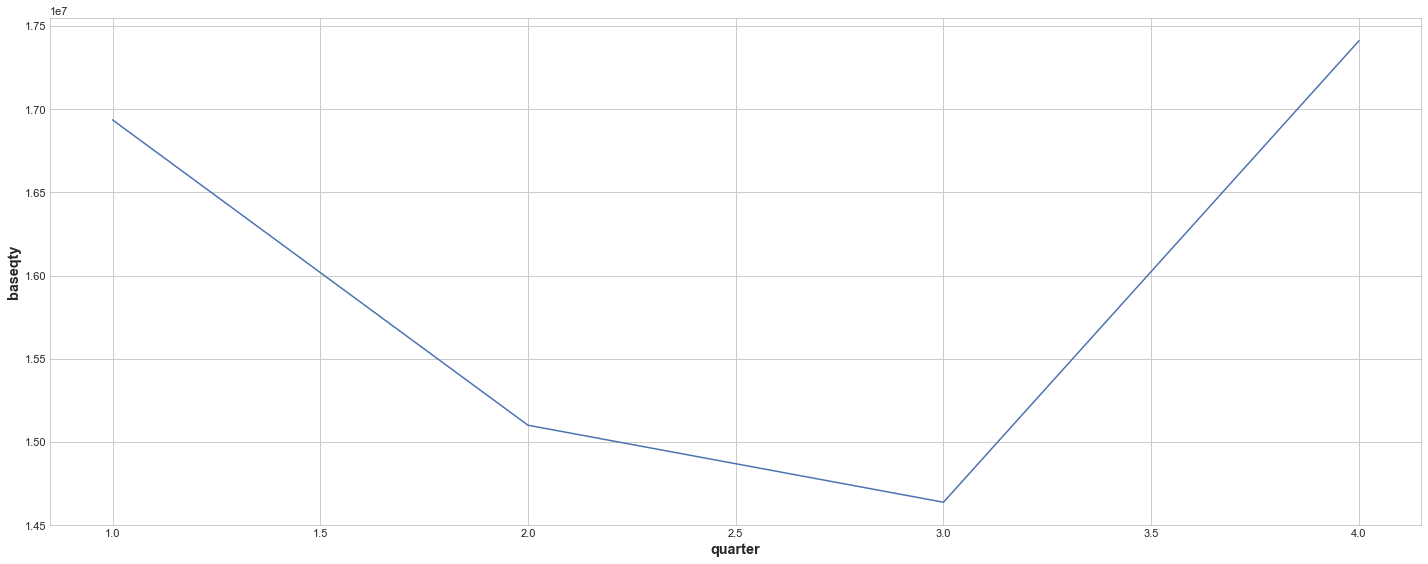

In [148]:
# baseqty by quarter
df_2.groupby('quarter').sum()['baseqty'].plot(figsize = (20,8))
plt.xlabel("quarter")
plt.ylabel("baseqty")

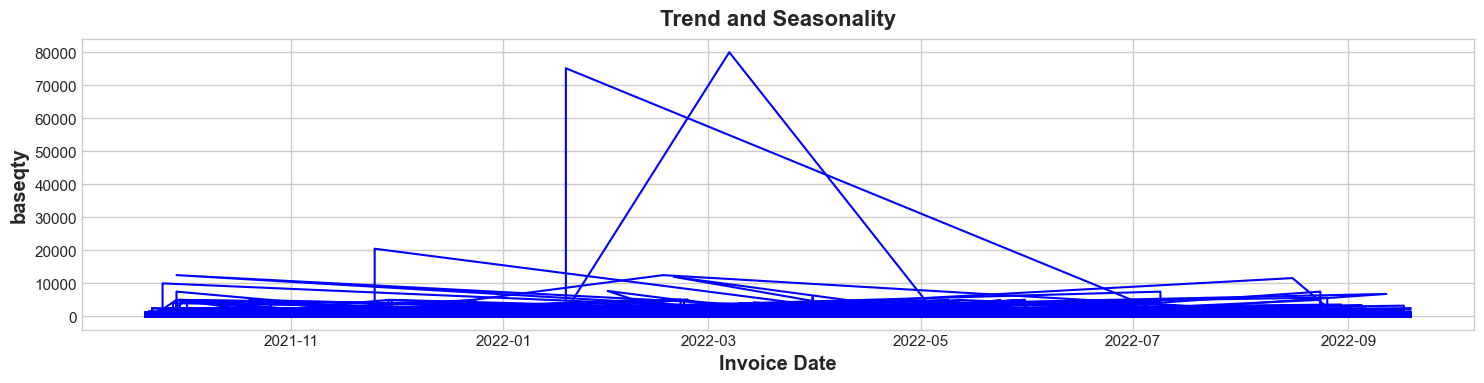

In [149]:
#seasonality check 
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

def plot_df(df, x, y, title="", xlabel='Invoice Date', ylabel='baseqty', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df_2, x=df_2['invoice_date'], y=df_2['baseqty'], title='Trend and Seasonality')
# no seasonality 

In [150]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099182 entries, 49 to 14292040
Data columns (total 20 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customercode     object        
 1   invoicenumber    object        
 2   invoice_date     datetime64[ns]
 3   productnameth    object        
 4   baseqty          int64         
 5   groupnamelevel1  object        
 6   groupnamelevel2  object        
 7   groupnamelevel3  object        
 8   dc_code          object        
 9   regionname       object        
 10  customertype     object        
 11  districtname     object        
 12  provincename     object        
 13  salesmancode     object        
 14  month            int64         
 15  day_of_week      int64         
 16  quarter          int64         
 17  week_of_year     int64         
 18  day              int64         
 19  weekend          int64         
dtypes: datetime64[ns](1), int64(7), object(12)
memory usage: 336.3+ MB

Text(0.5, 1.0, 'Quantity sold per month for province')

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3648 missing from current fon

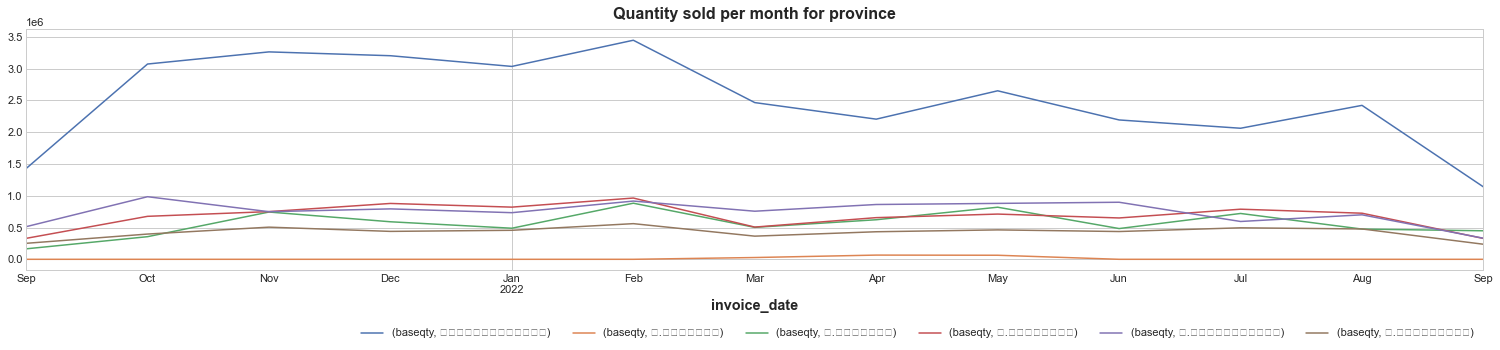

In [151]:
# reorganise data, group by store, date, productname
df_province_monthly_sales = (df_2.groupby(['invoice_date', 'provincename']).aggregate({'baseqty': 'sum'}).unstack().resample('1M').sum())

df_province_monthly_sales.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -.2), ncol=6)
plt.title("Quantity sold per month for province")

<AxesSubplot:xlabel='month'>

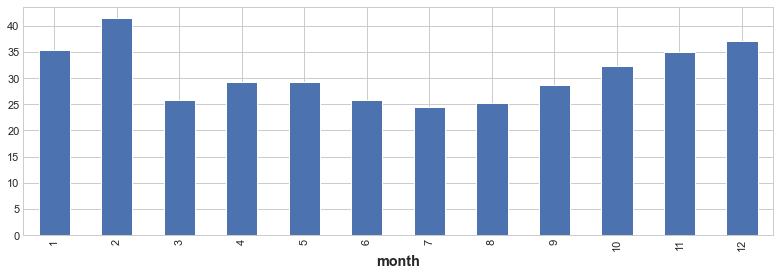

In [152]:
df_2.groupby('month')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='weekend'>

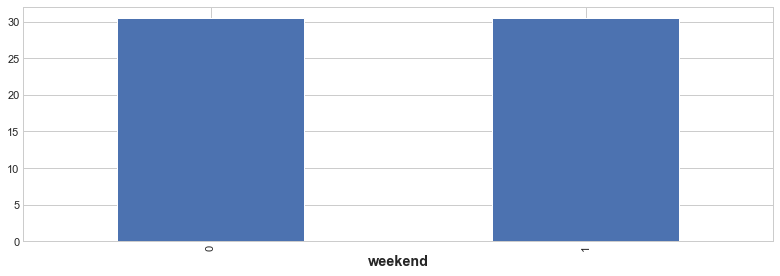

In [153]:
df_2.groupby('weekend')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='day'>

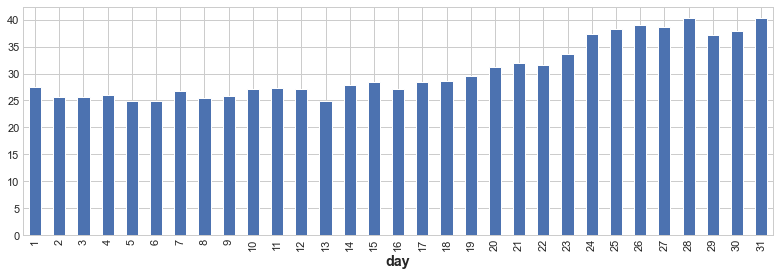

In [154]:
df_2.groupby('day')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='week_of_year'>

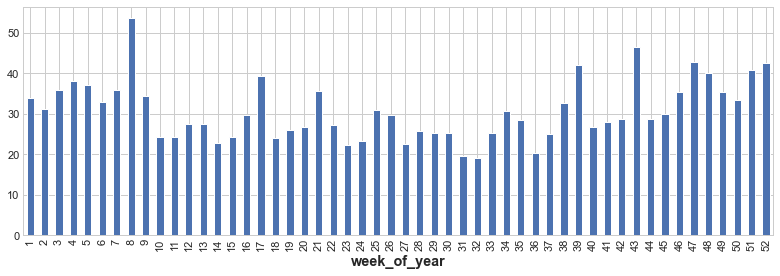

In [155]:
# week_of_year
df_2.groupby('week_of_year')['baseqty'].mean().plot.bar()

<AxesSubplot:xlabel='day_of_week'>

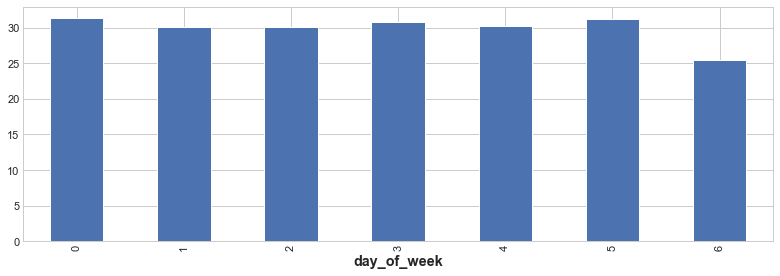

In [156]:
df_2.groupby('day_of_week')['baseqty'].mean().plot.bar()

In [157]:
daily_sale_dict = {}
for i in df_2.provincename.unique():
    daily_sale = df_2[df_2['provincename']==i]
    daily_sale_dict[i] = daily_sale

daily_sale_dict


{'กรุงเทพมหานคร':          customercode invoicenumber invoice_date  \
 49          MPS001526  IVZZ22200471   2022-04-02   
 58          PCP000941   HSP87B07052   2021-11-19   
 63          KIM000554  IVK362103180   2021-11-19   
 77          PCP000454   HSP89C01560   2022-03-21   
 83          URT001202   HSW94B04215   2021-10-23   
 ...               ...           ...          ...   
 14292036    STW003316   HSP84C02451   2022-06-04   
 14292037    STW002676   HSAG8C01473   2022-06-30   
 14292038    STW025261   HS792211686   2022-07-25   
 14292039    STW026335   HS792211714   2022-07-25   
 14292040    STW025023   HS792204591   2022-04-02   
 
                                      productnameth  baseqty groupnamelevel1  \
 49           เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10      250           M-150   
 58                       ลิโพวิตัน-ดี 100มล 1X5X10       10            LIPO   
 63                    ซี-วิท ทับทิม 140 มล. 1x3x10       10          C-VITT   
 77                      

In [158]:
daily_sale_dict.keys()

dict_keys(['กรุงเทพมหานคร', 'จ.นครนายก', 'จ.ปทุมธานี', 'จ.นนทบุรี', 'จ.สมุทรปราการ', 'จ.สมุทรสาคร'])

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3648 missing from current fon

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3641 missing from current fon

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3611 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3657 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3626 missing from current fon

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3655 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3632 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3635 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3608 missing from current fon

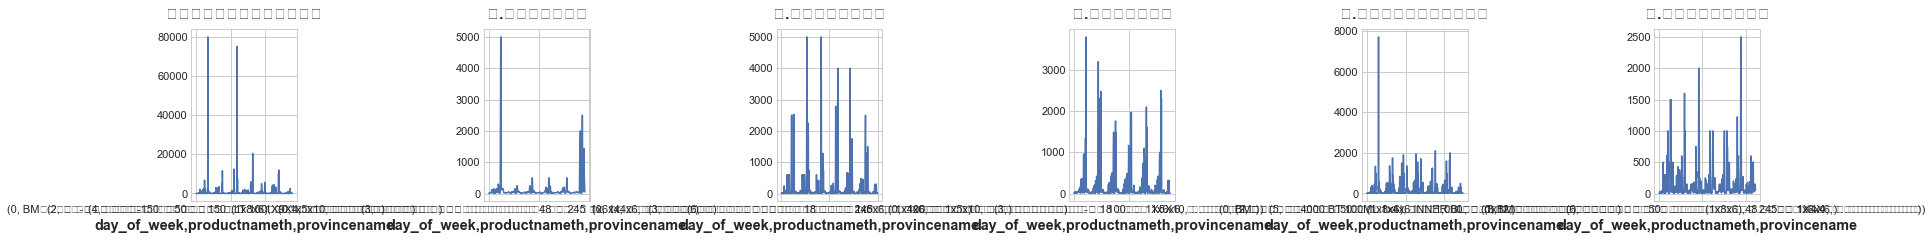

In [159]:
fig = plt.figure(figsize=(30,30))
inc = 1
for i in daily_sale_dict.keys():
    plt.subplot(8,7,inc)
    plt.title('{}'.format(i))
    plt.tight_layout(pad=5)
    sale = daily_sale_dict[i].groupby(['day_of_week','productnameth','provincename'])['baseqty'].max()
    sale.plot()
    inc += 1

In [160]:
df_2.head(3)

,customercode,invoicenumber,invoice_date,productnameth,baseqty,groupnamelevel1,groupnamelevel2,groupnamelevel3,dc_code,regionname,customertype,districtname,provincename,salesmancode,month,day_of_week,quarter,week_of_year,day,weekend
49,MPS001526,IVZZ22200471,2022-04-02,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,250,M-150,ENERGY DRINK,REGULAR,MPS,BKK2,โชว์ห่วยเล็ก (Community),เขตบางเขน,กรุงเทพมหานคร,MPSP01,4,5,2,13,2,1
58,PCP000941,HSP87B07052,2021-11-19,ลิโพวิตัน-ดี 100มล 1X5X10,10,LIPO,ENERGY DRINK,REGULAR,PCP,BKK1,โชว์ห่วยเล็ก (Community),เขตดอนเมือง,กรุงเทพมหานคร,PCPV01,11,4,4,46,19,0
63,KIM000554,IVK362103180,2021-11-19,ซี-วิท ทับทิม 140 มล. 1x3x10,10,C-VITT,REFRESHMENT,VITAMIN,KIM,BKK2,โชว์ห่วยเล็ก (Community),เขตบางพลัด,กรุงเทพมหานคร,KIMP03,11,4,4,46,19,0


In [161]:
tempRes = df_2.copy()

In [162]:
tempRes = tempRes.groupby(['day_of_week', 'productnameth','provincename'], as_index=False, sort=False)['baseqty'].sum()
tempRes = tempRes.sort_values(['day_of_week', 'productnameth','provincename','baseqty'],ascending=False)
tempRes = tempRes.groupby(['day_of_week', 'productnameth','provincename'], as_index=False, sort=False)['baseqty'].max()
tempRes.loc[tempRes['provincename'] == 'จ.แม่ฮ่องสอน']
# tempRes

,day_of_week,productnameth,provincename,baseqty


In [163]:
(tempRes
 .groupby(['provincename','day_of_week', 'productnameth'])['baseqty'].sum()
 .unstack('productnameth', fill_value=0)
 .groupby('provincename').cumsum()
 .idxmax(1)
 .reset_index()
)

tempRes.loc[tempRes['provincename'] == 'กรุงเทพมหานคร']


# tempRes['bqty_max'] = tempRes.groupby(['day_of_week', 'productnameth','provincename'])['baseqty'].transform(max)
# tempRes.drop_duplicates(['bqty_max']).nlargest(1, 'bqty_max')[['day_of_week', 'productnameth','provincename', 'bqty_max']]
# tempRes

,day_of_week,productnameth,provincename,baseqty
4,6,โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10,กรุงเทพมหานคร,2315
9,6,โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10),กรุงเทพมหานคร,6973
12,6,เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24),กรุงเทพมหานคร,7098
15,6,เอ็มเกลือแร่ 250มล. ขาว (1x24),กรุงเทพมหานคร,5457
20,6,เอ็มเกลือแร่ 250มล เหลือง 1x24,กรุงเทพมหานคร,5844
...,...,...,...,...
2428,0,คารามูโจ้แผ่นหยัก รสฮ๊อตชิลลี่ 48 กรัม 1x6x4,กรุงเทพมหานคร,4715
2432,0,คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6,กรุงเทพมหานคร,486
2437,0,คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6,กรุงเทพมหานคร,540
2440,0,คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24,กรุงเทพมหานคร,140


In [164]:
# # Which product to buy on different weekdays (region/province based) 
# df_2.groupby(['day_of_week','productnameth','provincename'])['baseqty'].sum().plot.bar()

In [165]:
df_3 = df_2.copy()
df_3.head()

,customercode,invoicenumber,invoice_date,productnameth,baseqty,groupnamelevel1,groupnamelevel2,groupnamelevel3,dc_code,regionname,customertype,districtname,provincename,salesmancode,month,day_of_week,quarter,week_of_year,day,weekend
49,MPS001526,IVZZ22200471,2022-04-02,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,250,M-150,ENERGY DRINK,REGULAR,MPS,BKK2,โชว์ห่วยเล็ก (Community),เขตบางเขน,กรุงเทพมหานคร,MPSP01,4,5,2,13,2,1
58,PCP000941,HSP87B07052,2021-11-19,ลิโพวิตัน-ดี 100มล 1X5X10,10,LIPO,ENERGY DRINK,REGULAR,PCP,BKK1,โชว์ห่วยเล็ก (Community),เขตดอนเมือง,กรุงเทพมหานคร,PCPV01,11,4,4,46,19,0
63,KIM000554,IVK362103180,2021-11-19,ซี-วิท ทับทิม 140 มล. 1x3x10,10,C-VITT,REFRESHMENT,VITAMIN,KIM,BKK2,โชว์ห่วยเล็ก (Community),เขตบางพลัด,กรุงเทพมหานคร,KIMP03,11,4,4,46,19,0
77,PCP000454,HSP89C01560,2022-03-21,ลิโพวิตัน-ดี 100มล 1X5X10,150,LIPO,ENERGY DRINK,REGULAR,PCP,BKK1,ร้าน O-Zone,เขตดอนเมือง,กรุงเทพมหานคร,PCPV01,3,0,1,12,21,0
83,URT001202,HSW94B04215,2021-10-23,เอ็ม-150 กระชายดำ LT 100มล. 1x5x10,10,M-150,ENERGY DRINK,REGULAR,URT,BKK1,โชว์ห่วยเล็ก (Community),เขตบางเขน,กรุงเทพมหานคร,URTV04,10,5,4,42,23,1


In [166]:
type(df_3['invoice_date'])

pandas.core.series.Series

In [167]:
df_3['invoice_date_week'] = df_3['invoice_date'] - pd.to_timedelta(7, unit='d')
min(df_3['invoice_date_week'])

Timestamp('2021-09-13 00:00:00')

In [168]:
df_3.head(3)

,customercode,invoicenumber,invoice_date,productnameth,baseqty,groupnamelevel1,groupnamelevel2,groupnamelevel3,dc_code,regionname,...,districtname,provincename,salesmancode,month,day_of_week,quarter,week_of_year,day,weekend,invoice_date_week
49,MPS001526,IVZZ22200471,2022-04-02,เอ็ม-150 ไฮ วิตามินบี12 150มล. 1x5x10,250,M-150,ENERGY DRINK,REGULAR,MPS,BKK2,...,เขตบางเขน,กรุงเทพมหานคร,MPSP01,4,5,2,13,2,1,2022-03-26
58,PCP000941,HSP87B07052,2021-11-19,ลิโพวิตัน-ดี 100มล 1X5X10,10,LIPO,ENERGY DRINK,REGULAR,PCP,BKK1,...,เขตดอนเมือง,กรุงเทพมหานคร,PCPV01,11,4,4,46,19,0,2021-11-12
63,KIM000554,IVK362103180,2021-11-19,ซี-วิท ทับทิม 140 มล. 1x3x10,10,C-VITT,REFRESHMENT,VITAMIN,KIM,BKK2,...,เขตบางพลัด,กรุงเทพมหานคร,KIMP03,11,4,4,46,19,0,2021-11-12


In [169]:
# to_be_merged = (
#       df_3.groupby(['invoice_date_week','productnameth','provincename','day_of_week'], sort=False)['baseqty']
#         .sum()
#         .unstack(fill_value=0)
#         .reset_index()
#         .rename_axis(None, axis=1)
#       )

to_be_merged = (
      df_3.groupby([pd.Grouper(key='invoice_date_week', freq='W'),pd.Grouper(key='productnameth'),pd.Grouper(key='provincename'),pd.Grouper(key='day_of_week')])['baseqty']
        .sum()
        .unstack(fill_value=0)
        .reset_index()
        .rename_axis(None, axis=1)
      )

# X_train9 = X_train9.groupby([pd.Grouper(level='provincename'),pd.Grouper(key='invoice_date_week', freq='W'),pd.Grouper(level='productnameth')])['baseqty','no_of_selling_pt','no_of_salesman','no_of_dc','no_of_invoice_count'].sum().sort_index()

#reset index 
to_be_merged.set_index(['provincename','invoice_date_week', 'productnameth'], inplace=True)
to_be_merged = to_be_merged.sort_index()
to_be_merged.head(60)

0  \
provincename  invoice_date_week productnameth                                       
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM          0   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8          88   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM           6   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM               0   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM             99   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6         48   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8      104   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6           342   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6         198   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6      288   
                                ฉลาม กระชายดำ 100ML 1x5x10                    240   
                                ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10         370   
                                ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10         4390   
                                ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4            20   
                                ซี-วิต วิตามินเลมอน 125มล. 1x9x4               44   
                                ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10       7140   
                                ซี-วิต เลมอน กล่องใหม่ 140มล 1x3x10          6070   
                                ยันฮี วิตามิน วอเตอร์ 460ML 1x12             3096   
                                ยันฮี วิตามิน วอเตอร์ 750ML 1x12               12   
                                ลิโพ-ไฟน์ 100มล 1X5X10                        205   
                                ลิโพวิตัน-ดี 100มล 1X5X10                   18010   
                                เบบี้มายด์แป้ง สวีทตี้พิงค์ 50ก. (6+2) 1X8      3   
                                เปปทีน พลัส BT 100ML 1x4x6 INNER SBM           48   
                                เปปทีน พลัส BT 100ML 1x4x6 SHRINK SBM           0   
                                เปปทีน4000 BT 100ML 1x4x6 INNER SBM            12   
                                เปปทีน4000 BT 100ML 1x4x6 SHRINK SBM            0   
                                เอ็ม-150 วิตามิน บี6 บี12 150 มล. 1x5x10    87300   
                                เอ็ม-150  กระชายดำ LT 100มล. 1x5x10          1560   
                                เอ็มเกลือแร่ 250มล. ขาว (1x24)                876   
                                เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)       1128   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)          1190   
                                โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10        615   
              2021-09-26        BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)              6   
                                คาลพิส มิกซ์เบอร์รี่ 140มล1x5x6NEWTIEHI         6   
                                คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM          6   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8          16   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM           6   
                                คาลพิส ออริจินัล 140มล 1x5x6 NEW TIEHI          6   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM             84   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6         24   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8       56   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6           384   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6         237   
                                คาลพิส โซดา ออริจินัลน้ำตาลน้อย245มล1X4X6       0   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6      225   
                                ฉลาม กระชายดำ 100ML 1x5x10                    150   


In [170]:
# to_be_merged.index.get_level_values('invoice_date_week')

In [171]:
df_4 = df_3[['provincename','invoice_date','productnameth','baseqty','customercode','salesmancode','dc_code','invoicenumber']]
df_4['invoice_date'] = df_4.invoice_date.dt.to_period('D')
df_4 = df_4.set_index(['provincename', 'invoice_date', 'productnameth']).groupby(['provincename', 'invoice_date', 'productnameth']).agg({'baseqty': 'sum','customercode':'nunique','salesmancode':'nunique','dc_code':'nunique','invoicenumber':'count'}).rename(columns={'baseqty':'baseqty','customercode':'no_of_selling_pt','salesmancode':'no_of_salesman','dc_code':'no_of_dc','invoicenumber':'no_of_invoice_count'}).sort_index()
df_4.head(30)

<ipython-input-171-f39d0204f8d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['invoice_date'] = df_4.invoice_date.dt.to_period('D')


baseqty  \
provincename  invoice_date productnameth                                         
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8            88   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM             6   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM               99   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6           48   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        104   
                           คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6             342   
                           คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6           198   
                           คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6        288   
                           ฉลาม กระชายดำ 100ML 1x5x10                      240   
                           ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10           370   
                           ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10           4390   
                           ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4              20   
                           ซี-วิต วิตามินเลมอน 125มล. 1x9x4                 44   
                           ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10         7140   
                           ซี-วิต เลมอน กล่องใหม่ 140มล 1x3x10            6070   
                           ยันฮี วิตามิน วอเตอร์ 460ML 1x12               3096   
                           ยันฮี วิตามิน วอเตอร์ 750ML 1x12                 12   
                           ลิโพ-ไฟน์ 100มล 1X5X10                          205   
                           ลิโพวิตัน-ดี 100มล 1X5X10                     18010   
                           เบบี้มายด์แป้ง สวีทตี้พิงค์ 50ก. (6+2) 1X8        3   
                           เปปทีน พลัส BT 100ML 1x4x6 INNER SBM             48   
                           เปปทีน4000 BT 100ML 1x4x6 INNER SBM              12   
                           เอ็ม-150 วิตามิน บี6 บี12 150 มล. 1x5x10      87300   
                           เอ็ม-150  กระชายดำ LT 100มล. 1x5x10            1560   
                           เอ็มเกลือแร่ 250มล. ขาว (1x24)                  876   
                           เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)         1128   
                           โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)            1190   
                           โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10          615   
              2021-09-21   คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM           36   
                           คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8            88   

                                                                       no_of_selling_pt  \
provincename  invoice_date productnameth                                                  
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8                      9   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM                      1   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM                        10   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6                    12   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8                  11   
                           คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6                       57   
                           คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6                     16   
                           คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6                  34   
                           ฉลาม กระชายดำ 100ML 1x5x10                                21   
                           ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10                     26   
                           ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10                     386   
                           ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4                        3   
                           ซี-วิต วิตามินเลมอน 125มล. 1x9x4                           4   
                           ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10                

In [172]:
# df_4.loc['จ.แม่ฮ่องสอน', :].tail(30)

In [173]:
df_4.shape

(43804, 5)

In [174]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43804 entries, ('กรุงเทพมหานคร', Period('2021-09-20', 'D'), 'คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8') to ('จ.สมุทรสาคร', Period('2022-09-19', 'D'), 'โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10')
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   baseqty              43804 non-null  int64
 1   no_of_selling_pt     43804 non-null  int64
 2   no_of_salesman       43804 non-null  int64
 3   no_of_dc             43804 non-null  int64
 4   no_of_invoice_count  43804 non-null  int64
dtypes: int64(5)
memory usage: 1.9+ MB


In [175]:
X_train9 = df_4.copy()

In [176]:
X_train9

baseqty  \
provincename  invoice_date productnameth                                       
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8          88   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM           6   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM             99   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6         48   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8      104   
...                                                                      ...   
จ.สมุทรสาคร   2022-09-19   เอ็มสปอร์ต ขาว 250มล. (1x4x6)                 120   
                           เอ็มสปอร์ต เหลือง 250มล. (1x4x6)              432   
                           เอ็มเกลือแร่ 250มล ขาว 1x24                    60   
                           โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)           290   
                           โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10        130   

                                                                     no_of_selling_pt  \
provincename  invoice_date productnameth                                                
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8                    9   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM                    1   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM                      10   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6                  12   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8                11   
...                                                                               ...   
จ.สมุทรสาคร   2022-09-19   เอ็มสปอร์ต ขาว 250มล. (1x4x6)                           13   
                           เอ็มสปอร์ต เหลือง 250มล. (1x4x6)                        58   
                           เอ็มเกลือแร่ 250มล ขาว 1x24                             10   
                           โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)                     16   
                           โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10                  16   

                                                                     no_of_salesman  \
provincename  invoice_date productnameth                                              
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8                  7   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM                  1   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM                     3   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6                 5   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8               8   
...                                                                             ...   
จ.สมุทรสาคร   2022-09-19   เอ็มสปอร์ต ขาว 250มล. (1x4x6)                          4   
                           เอ็มสปอร์ต เหลือง 250มล. (1x4x6)                       6   
                           เอ็มเกลือแร่ 250มล ขาว 1x24                            2   
                           โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)                    6   
                           โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10                 4   

                                                                     no_of_dc  \
provincename  invoice_date productnameth                                        
กรุงเทพมหานคร 2021-09-20   คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8            3   
                           คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM            1   
                           คาลพิส ออริจินัล 300 มล. 1x4x6 SBM               3   
                           คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6           3   
                           คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8         3   
...                                                                       ...   
จ.สมุทรสาคร   2022-09-19   เอ็มสปอร์ต ขาว 250มล. (1x4x6)                    1   
         

In [177]:
# group data by weeks
X_train9['invoice_date_week'] = X_train9.index.get_level_values('invoice_date').to_timestamp() - pd.to_timedelta(7, unit='d')

# # X_train9.head(3)
# #create weekday column
# dof_df = X_train9.copy()

# dof_df = dof_df.groupby(['day_of_week', 'productnameth','provincename',''], as_index=False, sort=False)['baseqty'].sum()
# dof_df = dof_df.sort_values(['day_of_week', 'productnameth','provincename','baseqty'],ascending=False)
# dof_df = dof_df.groupby(['day_of_week', 'productnameth','provincename'], as_index=False, sort=False)['baseqty'].max()

# (dof_df
#  .groupby(['provincename','day_of_week', 'productnameth'])['baseqty'].sum()
#  .unstack('productnameth', fill_value=0)
#  .groupby('provincename').cumsum()
#  .idxmax(1)
#  .reset_index()
# )

# dof_df.head(3)
#calculate sum of values, grouped by week
X_train9 = X_train9.groupby([pd.Grouper(level='provincename'),pd.Grouper(key='invoice_date_week', freq='W'),pd.Grouper(level='productnameth')])['baseqty','no_of_selling_pt','no_of_salesman','no_of_dc','no_of_invoice_count'].sum().sort_index()
X_train9.head(60)

<ipython-input-177-7d0f9e60af5b>:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  X_train9 = X_train9.groupby([pd.Grouper(level='provincename'),pd.Grouper(key='invoice_date_week', freq='W'),pd.Grouper(level='productnameth')])['baseqty','no_of_selling_pt','no_of_salesman','no_of_dc','no_of_invoice_count'].sum().sort_index()


baseqty  \
provincename  invoice_date_week productnameth                                         
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM          105   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8           472   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM           106   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM                18   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM              423   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6          222   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        600   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6            1478   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6           885   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6       1773   
                                ฉลาม กระชายดำ 100ML 1x5x10                      590   
                                ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10          1280   
                                ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10          28450   
                                ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4             192   
                                ซี-วิต วิตามินเลมอน 125มล. 1x9x4                204   
                                ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10        51110   
                                ซี-วิต เลมอน กล่องใหม่ 140มล 1x3x10           43420   
                                ยันฮี วิตามิน วอเตอร์ 460ML 1x12              20892   
                                ยันฮี วิตามิน วอเตอร์ 750ML 1x12                 24   
                                ลิโพ-ไฟน์ 100มล 1X5X10                         2214   
                                ลิโพวิตัน-ดี 100มล 1X5X10                    113080   
                                เบบี้มายด์แป้ง สวีทตี้พิงค์ 50ก. (6+2) 1X8       11   
                                เปปทีน พลัส BT 100ML 1x4x6 INNER SBM            126   
                                เปปทีน พลัส BT 100ML 1x4x6 SHRINK SBM            36   
                                เปปทีน4000 BT 100ML 1x4x6 INNER SBM             102   
                                เปปทีน4000 BT 100ML 1x4x6 SHRINK SBM             72   
                                เอ็ม-150 วิตามิน บี6 บี12 150 มล. 1x5x10     518000   
                                เอ็ม-150  กระชายดำ LT 100มล. 1x5x10            9140   
                                เอ็มเกลือแร่ 250มล. ขาว (1x24)                 6045   
                                เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)         7263   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)            6530   
                                โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10         3328   
              2021-09-26        BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)                6   
                                คาลพิส มิกซ์เบอร์รี่ 140มล1x5x6NEWTIEHI           6   
                                คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM           60   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8           256   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM            99   
                                คาลพิส ออริจินัล 140มล 1x5x6 NEW TIEHI            6   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM              327   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6          111   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        360   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6            1209   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6          1002   
                                คาลพิส โซดา ออริจินัลน้ำตาลน้อย245มล1X4X6         3   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6  

In [178]:
# min(X_train9['invoice_date_week'])

In [179]:
to_be_merged.sort_index()

0  \
provincename  invoice_date_week productnameth                                 
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM    0   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8    88   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM     6   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM         0   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM       99   
...                                                                     ...   
จ.สมุทรสาคร   2022-09-18        เอ็มสปอร์ต ขาว 250มล. (1x4x6)           120   
                                เอ็มสปอร์ต เหลือง 250มล. (1x4x6)        432   
                                เอ็มเกลือแร่ 250มล ขาว 1x24              60   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)     290   
                                โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10  130   

                                                                         1  \
provincename  invoice_date_week productnameth                                
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM  36   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   88   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   36   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM        0   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM      36   
...                                                                     ..   
จ.สมุทรสาคร   2022-09-18        เอ็มสปอร์ต ขาว 250มล. (1x4x6)            0   
                                เอ็มสปอร์ต เหลือง 250มล. (1x4x6)         0   
                                เอ็มเกลือแร่ 250มล ขาว 1x24              0   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)      0   
                                โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10   0   

                                                                          2  \
provincename  invoice_date_week productnameth                                 
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   30   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   104   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM    24   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM         0   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM       36   
...                                                                     ...   
จ.สมุทรสาคร   2022-09-18        เอ็มสปอร์ต ขาว 250มล. (1x4x6)             0   
                                เอ็มสปอร์ต เหลือง 250มล. (1x4x6)          0   
                                เอ็มเกลือแร่ 250มล ขาว 1x24               0   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)       0   
                                โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10    0   

                                                                          3  \
provincename  invoice_date_week productnameth                                 
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   15   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8    72   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM    28   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM         0   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM      102   
...                                                                     ...   
จ.สมุทรสาคร   2022-09-18        เอ็มสปอร์ต ขาว 250มล. (1x4x6)             0   
                                เอ็มสปอร์ต เหลือง 250มล. (1x4x6)          0   
                                เอ็มเกลือแร่ 250มล ขาว 1x24               0   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)       0   
                                โสมอินซัม พลัสเห็ดหลินจ

In [180]:
X_train9.head(50)

baseqty  \
provincename  invoice_date_week productnameth                                         
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM          105   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8           472   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM           106   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM                18   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM              423   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6          222   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        600   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6            1478   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6           885   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6       1773   
                                ฉลาม กระชายดำ 100ML 1x5x10                      590   
                                ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10          1280   
                                ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10          28450   
                                ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4             192   
                                ซี-วิต วิตามินเลมอน 125มล. 1x9x4                204   
                                ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10        51110   
                                ซี-วิต เลมอน กล่องใหม่ 140มล 1x3x10           43420   
                                ยันฮี วิตามิน วอเตอร์ 460ML 1x12              20892   
                                ยันฮี วิตามิน วอเตอร์ 750ML 1x12                 24   
                                ลิโพ-ไฟน์ 100มล 1X5X10                         2214   
                                ลิโพวิตัน-ดี 100มล 1X5X10                    113080   
                                เบบี้มายด์แป้ง สวีทตี้พิงค์ 50ก. (6+2) 1X8       11   
                                เปปทีน พลัส BT 100ML 1x4x6 INNER SBM            126   
                                เปปทีน พลัส BT 100ML 1x4x6 SHRINK SBM            36   
                                เปปทีน4000 BT 100ML 1x4x6 INNER SBM             102   
                                เปปทีน4000 BT 100ML 1x4x6 SHRINK SBM             72   
                                เอ็ม-150 วิตามิน บี6 บี12 150 มล. 1x5x10     518000   
                                เอ็ม-150  กระชายดำ LT 100มล. 1x5x10            9140   
                                เอ็มเกลือแร่ 250มล. ขาว (1x24)                 6045   
                                เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)         7263   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)            6530   
                                โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10         3328   
              2021-09-26        BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)                6   
                                คาลพิส มิกซ์เบอร์รี่ 140มล1x5x6NEWTIEHI           6   
                                คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM           60   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8           256   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM            99   
                                คาลพิส ออริจินัล 140มล 1x5x6 NEW TIEHI            6   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM              327   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6          111   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        360   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6            1209   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6          1002   
                                คาลพิส โซดา ออริจินัลน้ำตาลน้อย245มล1X4X6         3   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6  

In [181]:
min(to_be_merged.index.get_level_values('invoice_date_week'))

Timestamp('2021-09-19 00:00:00')

In [182]:
# merge two dataframe
# left join
X_train9 = X_train9.merge(to_be_merged, how="outer", left_index=True, right_index=True)
X_train9.rename(columns = {0:'Sun', 1:'Mon',2:'Tues',3:'Wed',4:'Thurs',5:'Fri',6:'Sat'}, inplace = True)
X_train9.head(60)

baseqty  \
provincename  invoice_date_week productnameth                                         
กรุงเทพมหานคร 2021-09-19        คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM          105   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8           472   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM           106   
                                คาลพิส ออริจินัล 300 มล. 1x24 SBM                18   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM              423   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6          222   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        600   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6            1478   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6           885   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6       1773   
                                ฉลาม กระชายดำ 100ML 1x5x10                      590   
                                ฉลามขาว วิตามินซี BOTTLE 150ML 1x5x10          1280   
                                ซี-วิต ทับทิม กล่องใหม่ 140มล 1x3x10          28450   
                                ซี-วิต วิตามินออเร้นจ์ 125มล. 1x9x4             192   
                                ซี-วิต วิตามินเลมอน 125มล. 1x9x4                204   
                                ซี-วิต ออเร้นจ์ กล่องใหม่ 140มล 1x3x10        51110   
                                ซี-วิต เลมอน กล่องใหม่ 140มล 1x3x10           43420   
                                ยันฮี วิตามิน วอเตอร์ 460ML 1x12              20892   
                                ยันฮี วิตามิน วอเตอร์ 750ML 1x12                 24   
                                ลิโพ-ไฟน์ 100มล 1X5X10                         2214   
                                ลิโพวิตัน-ดี 100มล 1X5X10                    113080   
                                เบบี้มายด์แป้ง สวีทตี้พิงค์ 50ก. (6+2) 1X8       11   
                                เปปทีน พลัส BT 100ML 1x4x6 INNER SBM            126   
                                เปปทีน พลัส BT 100ML 1x4x6 SHRINK SBM            36   
                                เปปทีน4000 BT 100ML 1x4x6 INNER SBM             102   
                                เปปทีน4000 BT 100ML 1x4x6 SHRINK SBM             72   
                                เอ็ม-150 วิตามิน บี6 บี12 150 มล. 1x5x10     518000   
                                เอ็ม-150  กระชายดำ LT 100มล. 1x5x10            9140   
                                เอ็มเกลือแร่ 250มล. ขาว (1x24)                 6045   
                                เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)         7263   
                                โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)            6530   
                                โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10         3328   
              2021-09-26        BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)                6   
                                คาลพิส มิกซ์เบอร์รี่ 140มล1x5x6NEWTIEHI           6   
                                คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM           60   
                                คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8           256   
                                คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM            99   
                                คาลพิส ออริจินัล 140มล 1x5x6 NEW TIEHI            6   
                                คาลพิส ออริจินัล 300 มล. 1x4x6 SBM              327   
                                คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6          111   
                                คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8        360   
                                คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6            1209   
                                คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6          1002   
                                คาลพิส โซดา ออริจินัลน้ำตาลน้อย245มล1X4X6         3   
                                คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6  

In [183]:
X_train9.index.get_level_values('invoice_date_week')

DatetimeIndex(['2021-09-19', '2021-09-19', '2021-09-19', '2021-09-19',
               '2021-09-19', '2021-09-19', '2021-09-19', '2021-09-19',
               '2021-09-19', '2021-09-19',
               ...
               '2022-09-18', '2022-09-18', '2022-09-18', '2022-09-18',
               '2022-09-18', '2022-09-18', '2022-09-18', '2022-09-18',
               '2022-09-18', '2022-09-18'],
              dtype='datetime64[ns]', name='invoice_date_week', length=9556, freq=None)

# Splitting Data to train/val/test

In [184]:
minDate = min(X_train9.index.get_level_values('invoice_date_week'))
maxDate = max(X_train9.index.get_level_values('invoice_date_week'))
print('this is the minDate:',minDate)
print('this is the maxDate:',maxDate)

this is the minDate: 2021-09-19 00:00:00
this is the maxDate: 2022-09-18 00:00:00


In [185]:
import datetime
from datetime import timedelta

full_train_start_day = minDate
full_train_end_day = maxDate

# data time range for validation split 
val_end_day = full_train_end_day
val_start_day = val_end_day - datetime.timedelta(weeks = 2)

# data time range for train
train_start_day = full_train_start_day 
train_end_day = val_end_day - datetime.timedelta(weeks = 3)

# data time range of test set
test_start_day = val_end_day + datetime.timedelta(weeks = 1)
# test_start_day = val_end_day + datetime.timedelta(days = 1)
test_end_day = test_start_day + datetime.timedelta(weeks = 2)

print('full_train_start_day',full_train_start_day)
print('full_train_end_day',full_train_end_day)
print('date duration:',(full_train_end_day - full_train_start_day).days, "\n")

print('train_start_day',train_start_day)
print('train_end_day',train_end_day)
print('date duration:',(train_end_day - train_start_day).days, "\n")

print('val_start_day',val_start_day)
print('val_end_day',val_end_day)
print('date duration:',(val_end_day - val_start_day).days, "\n")

print('test_start_day',test_start_day)
print('test_end_day',test_end_day)
print('date duration:',(test_end_day - test_start_day).days, "\n")

full_train_start_day 2021-09-19 00:00:00
full_train_end_day 2022-09-18 00:00:00
date duration: 364 

train_start_day 2021-09-19 00:00:00
train_end_day 2022-08-28 00:00:00
date duration: 343 

val_start_day 2022-09-04 00:00:00
val_end_day 2022-09-18 00:00:00
date duration: 14 

test_start_day 2022-09-25 00:00:00
test_end_day 2022-10-09 00:00:00
date duration: 14 



In [186]:
X_train10 = X_train9.unstack(['provincename', 'productnameth']).loc[full_train_start_day:full_train_end_day]
X_train11 = X_train10.fillna(0)
X_train11

baseqty  \
provincename                               กรุงเทพมหานคร   
productnameth     คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   
invoice_date_week                                          
2021-09-19                                         105.0   
2021-09-26                                          60.0   
2021-10-03                                         204.0   
2021-10-10                                         138.0   
2021-10-17                                         174.0   
2021-10-24                                         228.0   
2021-10-31                                         276.0   
2021-11-07                                         138.0   
2021-11-14                                         210.0   
2021-11-21                                         150.0   
2021-11-28                                         228.0   
2021-12-05                                         294.0   
2021-12-12                                         216.0   
2021-12-19                                         273.0   
2021-12-26                                         129.0   
2022-01-02                                         384.0   
2022-01-09                                         462.0   
2022-01-16                                         593.0   
2022-01-23                                         381.0   
2022-01-30                                         388.0   
2022-02-06                                         546.0   
2022-02-13                                         414.0   
2022-02-20                                         456.0   
2022-02-27                                         356.0   
2022-03-06                                         438.0   
2022-03-13                                         387.0   
2022-03-20                                         447.0   
2022-03-27                                         315.0   
2022-04-03                                         498.0   
2022-04-10                                         155.0   
2022-04-17                                         414.0   
2022-04-24                                         204.0   
2022-05-01                                         267.0   
2022-05-08                                         351.0   
2022-05-15                                         936.0   
2022-05-22                                         487.0   
2022-05-29                                         402.0   
2022-06-05                                         216.0   
2022-06-12                                         268.0   
2022-06-19                                         330.0   
2022-06-26                                         324.0   
2022-07-03                                         189.0   
2022-07-10                                         215.0   
2022-07-17                                         265.0   
2022-07-24                                         363.0   
2022-07-31                                         267.0   
2022-08-07                                         270.0   
2022-08-14                                         351.0   
2022-08-21                                         285.0   
2022-08-28                                         306.0   
2022-09-04                                         429.0   
2022-09-11                                         500.0   
2022-09-18                                          78.0   

                                                         \
provincename                                              
productnameth     คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date_week                                         
2021-09-19                                        472.0   
2021-09-26                                        256.0   
2021-10-03                                        512.0   
2021-10-10                                        352.0   
2021-10-17                                        400.0   
2021-10-24                                        352.0   
2021-10-31                            

In [187]:
# # standardize
# def standardize(df):
    
#     scaler = MinMaxScaler()
#     cols = df.columns
#     idx = df.index

#     # transform data
#     scaled = scaler.fit_transform(df)
#     df = pd.DataFrame(scaled, columns=cols,index = idx)
#     return df

# X_train11 = standardize(X_train11)

## Create and concat test dataset (next 16 days)

In [188]:
new_index = pd.date_range(test_start_day, test_end_day,freq='1w')
# new_index = new_index.to_period('W')
df_test = pd.DataFrame(np.nan, index=new_index, columns=X_train11.columns)
df_test = pd.DataFrame(0, index=new_index, columns=X_train11.columns)
df_test.index.name = 'invoice_date_week'
df_test

baseqty  \
provincename                               กรุงเทพมหานคร   
productnameth     คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   
invoice_date_week                                          
2022-09-25                                             0   
2022-10-02                                             0   
2022-10-09                                             0   

                                                         \
provincename                                              
productnameth     คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date_week                                         
2022-09-25                                            0   
2022-10-02                                            0   
2022-10-09                                            0   

                                                         \
provincename                                              
productnameth     คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   
invoice_date_week                                         
2022-09-25                                            0   
2022-10-02                                            0   
2022-10-09                                            0   

                                                     \
provincename                                          
productnameth     คาลพิส ออริจินัล 300 มล. 1x24 SBM   
invoice_date_week                                     
2022-09-25                                        0   
2022-10-02                                        0   
2022-10-09                                        0   

                                                      \
provincename                                           
productnameth     คาลพิส ออริจินัล 300 มล. 1x4x6 SBM   
invoice_date_week                                      
2022-09-25                                         0   
2022-10-02                                         0   
2022-10-09                                         0   

                                                          \
provincename                                               
productnameth     คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6   
invoice_date_week                                          
2022-09-25                                             0   
2022-10-02                                             0   
2022-10-09                                             0   

                                                            \
provincename                                                 
productnameth     คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8   
invoice_date_week                                            
2022-09-25                                               0   
2022-10-02                                               0   
2022-10-09                                               0   

                                                       \
provincename                                            
productnameth     คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6   
invoice_date_week                                       
2022-09-25                                          0   
2022-10-02                                          0   
2022-10-09                                          0   

                                                         \
provincename                                              
productnameth     คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6   
invoice_date_week                                         
2022-09-25                                            0   
2022-10-02                                            0   
2022-10-09                                            0   

                                                            ...  \
provincename                                                ...   
productnameth     คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6  ...   
invoice_date_week                                           ...   
2022-09-25                                               0  ...   
2022-10-02      

In [189]:
final_dataset = pd.concat([X_train11,df_test])
final_dataset.tail(30)

baseqty  \
provincename                               กรุงเทพมหานคร   
productnameth     คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   
invoice_date_week                                          
2022-03-20                                         447.0   
2022-03-27                                         315.0   
2022-04-03                                         498.0   
2022-04-10                                         155.0   
2022-04-17                                         414.0   
2022-04-24                                         204.0   
2022-05-01                                         267.0   
2022-05-08                                         351.0   
2022-05-15                                         936.0   
2022-05-22                                         487.0   
2022-05-29                                         402.0   
2022-06-05                                         216.0   
2022-06-12                                         268.0   
2022-06-19                                         330.0   
2022-06-26                                         324.0   
2022-07-03                                         189.0   
2022-07-10                                         215.0   
2022-07-17                                         265.0   
2022-07-24                                         363.0   
2022-07-31                                         267.0   
2022-08-07                                         270.0   
2022-08-14                                         351.0   
2022-08-21                                         285.0   
2022-08-28                                         306.0   
2022-09-04                                         429.0   
2022-09-11                                         500.0   
2022-09-18                                          78.0   
2022-09-25                                           0.0   
2022-10-02                                           0.0   
2022-10-09                                           0.0   

                                                         \
provincename                                              
productnameth     คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date_week                                         
2022-03-20                                          0.0   
2022-03-27                                          0.0   
2022-04-03                                          0.0   
2022-04-10                                          0.0   
2022-04-17                                          0.0   
2022-04-24                                          0.0   
2022-05-01                                          0.0   
2022-05-08                                          0.0   
2022-05-15                                          0.0   
2022-05-22                                          0.0   
2022-05-29                                          0.0   
2022-06-05                                          0.0   
2022-06-12                                         32.0   
2022-06-19                                          0.0   
2022-06-26                                          0.0   
2022-07-03                                         64.0   
2022-07-10                                         32.0   
2022-07-17                                         48.0   
2022-07-24                                        128.0   
2022-07-31                                        184.0   
2022-08-07                                         16.0   
2022-08-14                                         32.0   
2022-08-21                                         16.0   
2022-08-28                                         32.0   
2022-09-04                                         88.0   
2022-09-11                                         32.0   
2022-09-18                                          8.0   
2022-09-25                                          0.0   
2022-10-02                                          0.0   
2022-10-09                                          0.0   

 

In [190]:
type(final_dataset.index.get_level_values('invoice_date_week'))

pandas.core.indexes.datetimes.DatetimeIndex

# LGBM

In [191]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

In [192]:
def encode_categoricals(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

def make_X2_lags(ts, lags, lead_time=1, name='y', stack_cols=None):

    ts = ts.unstack(stack_cols)
    df = pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i, freq="W") # freq adds i extra day(s) to end: only one extra day is needed so rest will be dropped
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    df = df.stack(stack_cols).reset_index()
    df = encode_categoricals(df, stack_cols)
    df = df.set_index('invoice_date_week').sort_values(by=stack_cols) # return sorted so can correctly compute rolling means (if desired)
    return df

In [193]:
# try
def shaping(df,stack_columns=None):
    stack_columns = ['provincename', 'productnameth']

    shifted_qty_df = make_X2_lags(df['baseqty'], lags=2, name='qty', stack_cols=stack_columns)
    shifted_qty_df['qty_mean_rolling_5'] = shifted_qty_df['qty_lag_1'].rolling(window=5, center=False).mean()
    shifted_qty_df['qty_median_rolling_10'] = shifted_qty_df['qty_lag_1'].rolling(window=10, center=False).median().fillna(method='bfill')
    shifted_qty_df['qty_median_rolling_15'] = shifted_qty_df['qty_lag_1'].rolling(window=15, center=False).median().fillna(method='bfill')
    
    # other features
    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)
    
    X2["day_of_week"] = X2.index.dayofweek # does absolutely nothing alone
    X2 = encode_categoricals(df, ['day_of_week'])
    
    # extract month from date
    X2['month'] = X2.index.month
    X2 = encode_categoricals(df, ['month'])

#     # quarter
#     X2['quarter'] = X2.index.quarter
#     X2 = encode_categoricals(df, ['quarter'])

    # week of year
    X2['week_of_year'] = X2.index.weekofyear
    X2 = encode_categoricals(df, ['week_of_year'])

    # day
    X2['day'] = X2.index.day
    X2 = encode_categoricals(df, ['day'])
    
#     # weekend
#     X2['is_weekend'] = X2['day_of_week'].isin([5,6])
    
    X2 = X2.merge(shifted_qty_df, on=['invoice_date_week', 'provincename', 'productnameth'], how='left')
    
    # standardize 
#     X2 = standardize(X2)

    return X2

In [194]:
X_2 = shaping(final_dataset.stack(['provincename','productnameth']))
X_2 = X_2.fillna(0)

# full train
full_train = X_2.loc[full_train_start_day:full_train_end_day]

# setting up train
train = X_2.loc[train_start_day:train_end_day]
X_train = train.loc[:, train.columns != 'baseqty']
Y_train = train['baseqty']

# setting up validation
validation = X_2.loc[val_start_day:val_end_day]
X_validation = validation.loc[:, validation.columns != 'baseqty']
Y_validation = validation['baseqty']

# setting up test
test = X_2.loc[test_start_day:test_end_day]
X_test = test.loc[:, test.columns != 'baseqty']
Y_test = test['baseqty']

Y_train.shape, X_train.shape, Y_validation.shape, X_validation.shape

<ipython-input-193-5c8a12f7f0a2>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X2['week_of_year'] = X2.index.weekofyear


((19950,), (19950, 22), (1197,), (1197, 22))

In [195]:
test

,provincename,productnameth,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,baseqty,...,no_of_selling_pt,day_of_week,month,week_of_year,day,qty_lag_1,qty_lag_2,qty_mean_rolling_5,qty_median_rolling_10,qty_median_rolling_15
invoice_date_week,,,,,,,,,,,,,,,,,,,,,
2022-09-25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,0.0,0.0,0.0,0.0,0.0
2022-09-25,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,0.0,0.0,4.8,6.0,6.0
2022-09-25,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,0.0,192.0,137.2,92.0,4.0
2022-09-25,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,6.0,77.0,74.4,58.5,69.0
2022-09-25,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,24.0,52.0,65.4,63.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09,5,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,9,39,8,0.0,0.0,0.0,27.0,1794.0
2022-10-09,5,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,9,39,8,0.0,0.0,0.0,0.0,0.0
2022-10-09,5,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,9,39,8,0.0,0.0,0.0,0.0,0.0


In [196]:
train

,provincename,productnameth,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,baseqty,...,no_of_selling_pt,day_of_week,month,week_of_year,day,qty_lag_1,qty_lag_2,qty_mean_rolling_5,qty_median_rolling_10,qty_median_rolling_15
invoice_date_week,,,,,,,,,,,,,,,,,,,,,
2021-09-19,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,36,18,0.0,0.0,0.0,0.0,0.0
2021-09-19,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,36,18,0.0,0.0,0.0,0.0,0.0
2021-09-19,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,36,18,0.0,0.0,0.0,0.0,0.0
2021-09-19,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,36,18,0.0,0.0,0.0,0.0,0.0
2021-09-19,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,36,18,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-28,5,89,0.0,0.0,0.0,24.0,0.0,30.0,0.0,54.0,...,6.0,0,7,33,27,456.0,2580.0,2476.6,3081.0,3768.0
2022-08-28,5,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,7,33,27,0.0,0.0,0.0,0.0,0.0
2022-08-28,5,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,7,33,27,0.0,0.0,0.0,0.0,0.0


In [197]:
import lightgbm as lgb
first_model = lgb.LGBMRegressor(random_state=384).fit(X_train, Y_train, eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, first_model.predict(X_train)))
print("VALID SMAPE:", smape(Y_validation, first_model.predict(X_validation)))

TRAIN SMAPE: 119.39966666266835
VALID SMAPE: 120.25425764713907


In [198]:
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns
    
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(first_model, num=50)

                  feature  split       gain
7                    Tues    270  39.272521
8                     Wed    339  18.183407
3                     Mon    315  18.128252
6                   Thurs    245  11.529270
5                     Sun    416   6.232704
2                     Fri    289   4.320557
12       no_of_selling_pt     39   1.229610
11         no_of_salesman    131   0.320401
4                     Sat    194   0.313732
9                no_of_dc    106   0.159896
19     qty_mean_rolling_5     89   0.112915
17              qty_lag_1    108   0.064261
10    no_of_invoice_count     89   0.062502
21  qty_median_rolling_15     98   0.034298
15           week_of_year     54   0.011515
16                    day     42   0.010670
20  qty_median_rolling_10     70   0.005753
18              qty_lag_2     61   0.004715
1           productnameth     28   0.002098
14                  month     11   0.000565
0            provincename      6   0.000358
13            day_of_week      0

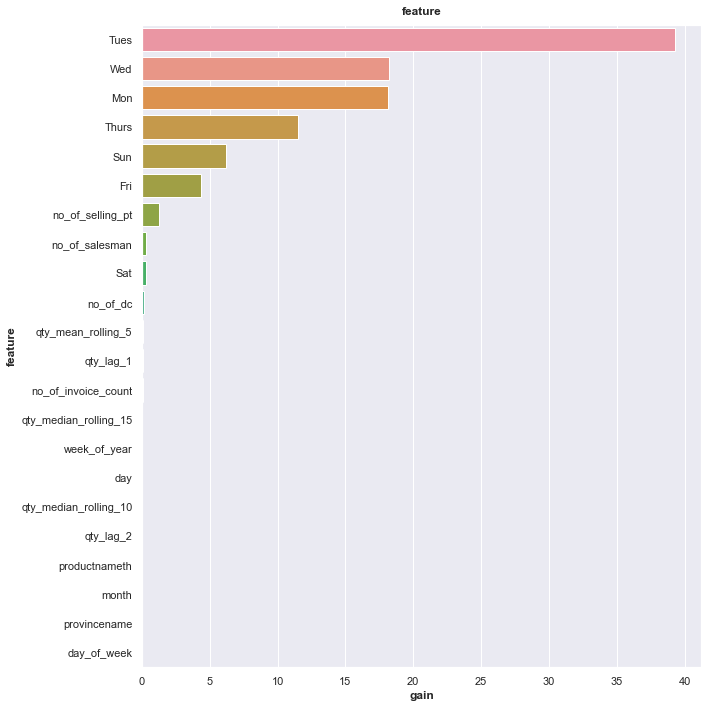

In [199]:
plot_lgb_importances(first_model, plot=True, num=30)

In [200]:
error = pd.DataFrame({
    "date":validation.index.get_level_values('invoice_date_week'),
    "provincename":X_validation.provincename,
    "productnameth":X_validation.productnameth,
    "actual":Y_validation,
    "pred":first_model.predict(X_validation)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)
error.sort_values("error", ascending=False)

,date,provincename,productnameth,actual,pred,error
877,2022-09-18,0,82,21825.0,3825.833652,17999.166348
857,2022-09-18,0,62,23750.0,10891.437088,12858.562912
478,2022-09-11,0,82,194803.0,182138.514154,12664.485846
974,2022-09-18,2,82,15830.0,9122.784217,6707.215783
79,2022-09-04,0,82,171480.0,166532.699377,4947.300623
...,...,...,...,...,...,...
375,2022-09-04,5,63,78.0,77.722308,0.277692
678,2022-09-11,4,32,4.0,3.977295,0.022705
279,2022-09-04,4,32,4.0,3.977295,0.022705
1054,2022-09-18,4,2,4.0,3.977295,0.022705


In [201]:
error.groupby(["provincename", "productnameth"]).error.mean().sort_values(ascending = False)

provincename  productnameth
0             82               11870.317606
              62                6009.296884
2             82                2625.646568
              62                2371.508436
3             82                1991.035382
                                   ...     
5             11                   2.389012
              63                   2.092564
0             68                   1.641950
4             32                   1.340902
              2                    0.675774
Name: error, Length: 399, dtype: float64

In [202]:
error.groupby(["provincename"]).error.mean().sort_values(ascending = False)

provincename
0    311.870633
2    134.587721
3     86.481609
5     70.353249
4     57.343294
1      3.977295
Name: error, dtype: float64

In [203]:
error.loc[error['date'] == '2021-09-13']

,date,provincename,productnameth,actual,pred,error


<AxesSubplot:xlabel='date'>

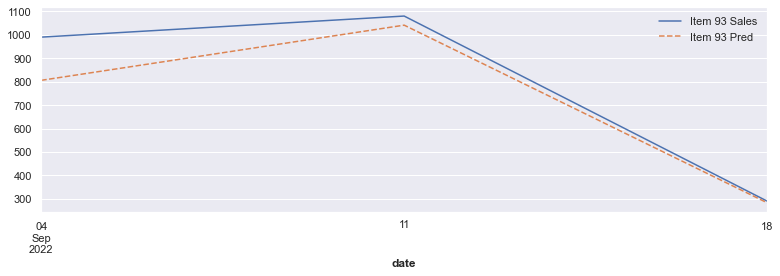

In [204]:
sub = error[error.provincename == 5].set_index("date")
sub[sub.productnameth == 93].actual.plot(legend=True, label = "Item "+str(93)+" Sales")
sub[sub.productnameth == 93].pred.plot(legend=True, label="Item " + str(93) + " Pred", linestyle = "dashed")

## Feature Selection

before feature selection:

TRAIN SMAPE: 154.94503908139677
VALID SMAPE: 153.03089040740352

In [205]:
cols = feature_imp_df[feature_imp_df.gain > 0.015].feature.tolist()
print("Independent Variables:", len(cols))
print(cols)

second_model = lgb.LGBMRegressor(random_state=384).fit(
    X_train[cols], Y_train, 
    eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(Y_train, second_model.predict(X_train[cols])))
print("VALID SMAPE:", smape(Y_validation, second_model.predict(X_validation[cols])))

Independent Variables: 14
['Tues', 'Wed', 'Mon', 'Thurs', 'Sun', 'Fri', 'no_of_selling_pt', 'no_of_salesman', 'Sat', 'no_of_dc', 'qty_mean_rolling_5', 'qty_lag_1', 'no_of_invoice_count', 'qty_median_rolling_15']
TRAIN SMAPE: 119.60379663064509
VALID SMAPE: 119.5689178054697


## Forecast

In [206]:
error = pd.DataFrame({
    "date":validation.index.get_level_values('invoice_date_week'),
    "provincename":X_validation.provincename,
    "productnameth":X_validation.productnameth,
    "actual":Y_validation,
    "pred":first_model.predict(X_validation)
}).reset_index(drop = True)

In [207]:
test

,provincename,productnameth,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,baseqty,...,no_of_selling_pt,day_of_week,month,week_of_year,day,qty_lag_1,qty_lag_2,qty_mean_rolling_5,qty_median_rolling_10,qty_median_rolling_15
invoice_date_week,,,,,,,,,,,,,,,,,,,,,
2022-09-25,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,0.0,0.0,0.0,0.0,0.0
2022-09-25,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,0.0,0.0,4.8,6.0,6.0
2022-09-25,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,0.0,192.0,137.2,92.0,4.0
2022-09-25,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,6.0,77.0,74.4,58.5,69.0
2022-09-25,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,8,37,24,24.0,52.0,65.4,63.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09,5,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,9,39,8,0.0,0.0,0.0,27.0,1794.0
2022-10-09,5,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,9,39,8,0.0,0.0,0.0,0.0,0.0
2022-10-09,5,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,9,39,8,0.0,0.0,0.0,0.0,0.0


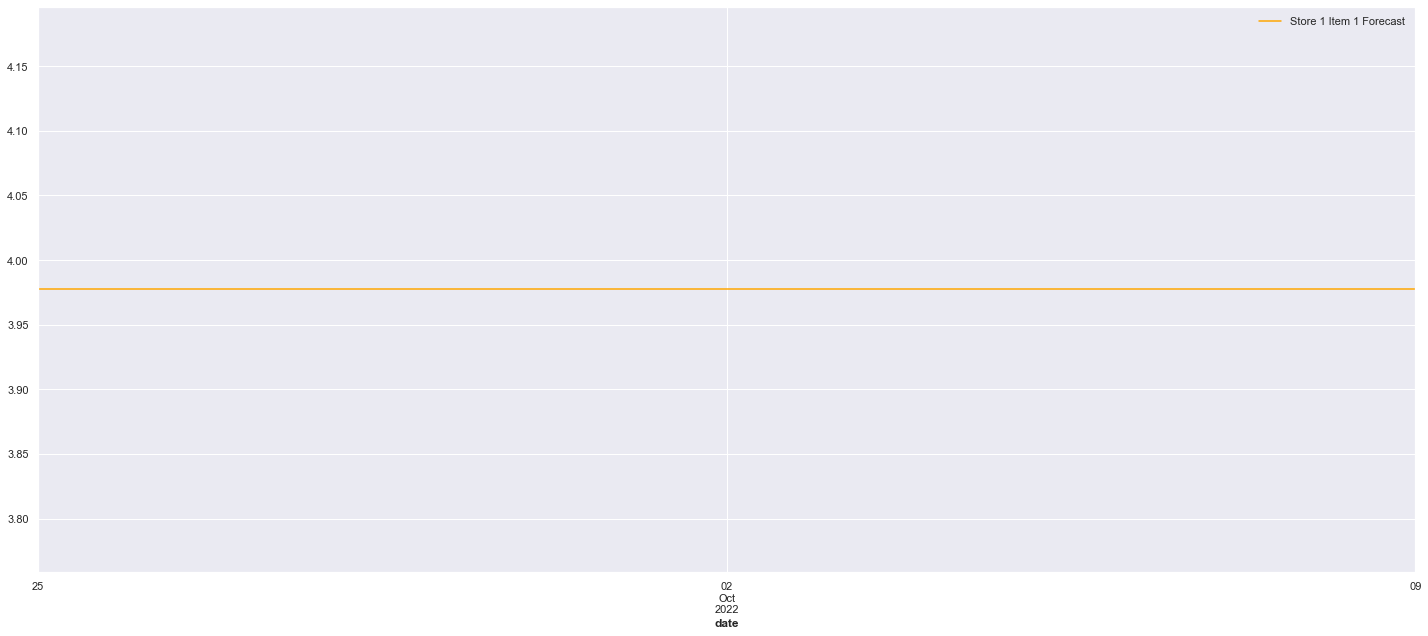

In [208]:
forecast = pd.DataFrame({
    "date":test.index.get_level_values('invoice_date_week'),
    "provincename":test.provincename,
    "productnameth":test.productnameth,
    "baseqty":first_model.predict(X_test)
})

forecast[(forecast.provincename == 5) & (forecast.productnameth == 93)].set_index("date").baseqty.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

In [209]:
forecast[(forecast.provincename == 5) & (forecast.productnameth == 93)]

,date,provincename,productnameth,baseqty
invoice_date_week,,,,
2022-09-25,2022-09-25,5,93,3.977295
2022-10-02,2022-10-02,5,93,3.977295
2022-10-09,2022-10-09,5,93,3.977295


In [210]:
forecast.tail(100)

,date,provincename,productnameth,baseqty
invoice_date_week,,,,
2022-10-09,2022-10-09,4,57,3.977295
2022-10-09,2022-10-09,4,58,3.977295
2022-10-09,2022-10-09,4,59,-0.869526
2022-10-09,2022-10-09,4,60,3.977295
2022-10-09,2022-10-09,4,62,3.977295
...,...,...,...,...
2022-10-09,2022-10-09,5,89,3.977295
2022-10-09,2022-10-09,5,90,3.977295
2022-10-09,2022-10-09,5,91,3.977295


In [211]:
validation[(validation.provincename == 5) & (validation.productnameth == 93)]

,provincename,productnameth,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,baseqty,...,no_of_selling_pt,day_of_week,month,week_of_year,day,qty_lag_1,qty_lag_2,qty_mean_rolling_5,qty_median_rolling_10,qty_median_rolling_15
invoice_date_week,,,,,,,,,,,,,,,,,,,,,
2022-09-04,5,93,130.0,240.0,20.0,50.0,130.0,230.0,190.0,990.0,...,65.0,0,8,34,3,1823.0,1430.0,1606.6,1535.0,1430.0
2022-09-11,5,93,130.0,40.0,0.0,230.0,180.0,80.0,420.0,1080.0,...,94.0,0,8,35,10,990.0,1823.0,1606.6,1535.0,1430.0
2022-09-18,5,93,0.0,0.0,0.0,290.0,0.0,0.0,0.0,290.0,...,16.0,0,8,36,17,1080.0,990.0,1494.6,1385.0,1430.0


In [212]:
forecast[(forecast.provincename == 5) & (forecast.productnameth == 93)]

,date,provincename,productnameth,baseqty
invoice_date_week,,,,
2022-09-25,2022-09-25,5,93,3.977295
2022-10-02,2022-10-02,5,93,3.977295
2022-10-09,2022-10-09,5,93,3.977295


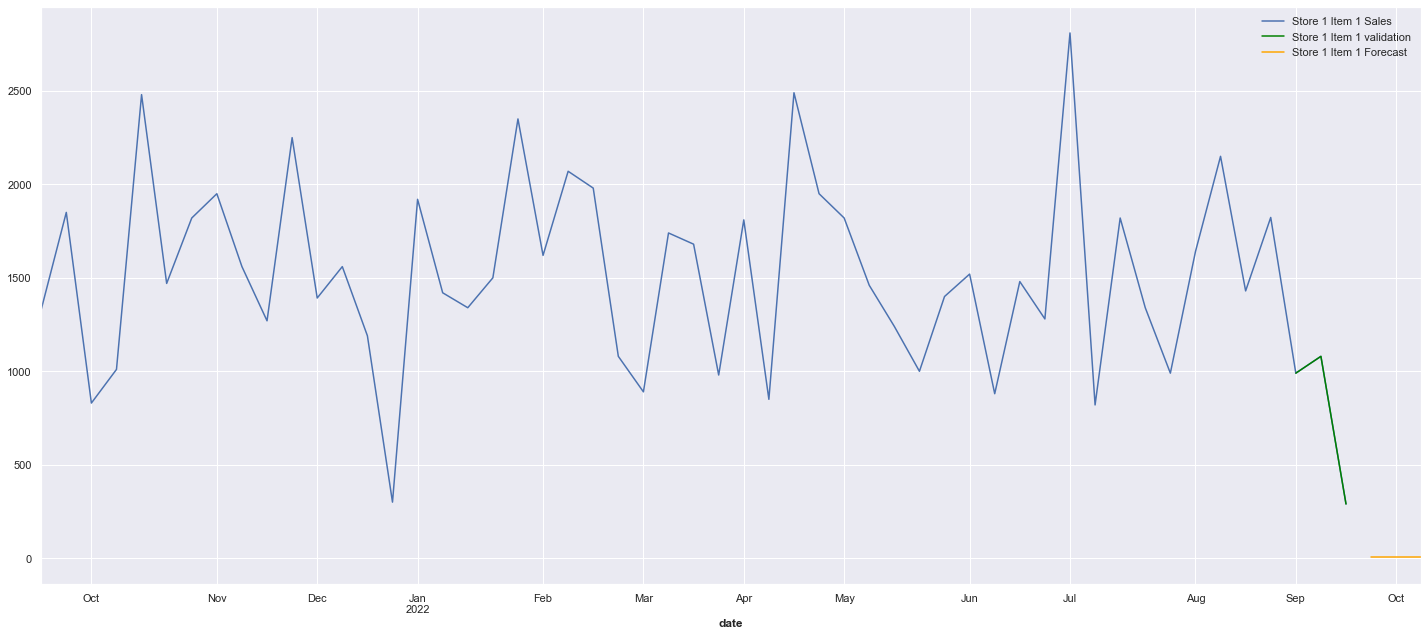

In [213]:
full_train[(full_train.provincename == 5) & (full_train.productnameth == 93)].baseqty.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
validation[(validation.provincename == 5) & (validation.productnameth == 93)].baseqty.plot(color = "green", figsize = (20,9),legend=True, label = "Store 1 Item 1 validation")
forecast[(forecast.provincename == 5) & (forecast.productnameth == 93)].set_index("date").baseqty.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

# XGBOOST

# LINEAR + XGBOOST 

In [214]:
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# pre-forecast setting
# lag- > moving the original data forward n period
max_lag = 0
mod_1 = LinearRegression()
mod_2 = XGBRegressor()

hybrid_forecasting_type = "direct" # possible values: day_by_day_refit_all_days, day_by_day_fixed_past, or direct

In [215]:
# preparing hybrid model
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None
        self.y_resid = None

    def fit1(self, X_1, y, stack_cols=None):
        self.model_1.fit(X_1, y) # train model 1
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), # predict from model 1
            index=X_1.index,
            columns=y.columns,
        )
        self.y_resid = y - y_fit # residuals from model 1, which X2 may want to access to create lag (or other) features
        self.y_resid = self.y_resid.stack(stack_cols).squeeze()  # wide to long
        
    def predict(self, X_1, X_2, first_n_rows_to_ignore):
    
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()
#         print('this is the ypred result:',y_pred, ' the length is:',len(y_pred))
#         print('this is the ypred result for X_2:',self.model_2.predict(X_2),' the length is:',len(self.model_2.predict(X_2)))
        y_pred += self.model_2.predict(X_2) # Add model_2 predictions to model_1 predictions
        print('this is the final ypred result:',y_pred)
        return y_pred.unstack(self.stack_cols)
        
    def fit2(self, X_2, first_n_rows_to_ignore, stack_cols=None):
#         print('self.y_resid:',self.y_resid)
#         print('X_2:',X_2)
        
        self.model_2.fit(X_2, self.y_resid) # Train model_2
        self.y_columns = y.columns # Save for predict method
        self.stack_cols = stack_cols # Save for predict method

In [216]:
# create X1 features
def make_dp_features(df):
    y = df.loc[:, 'baseqty']
    
    fourier_m = CalendarFourier(freq='W', order=4)
    dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
#         seasonal=True,
        # seasonal=True, # note how this generates terms Tue - Sun: s(2,7) through s(7,7) (trend column: Monday)
        additional_terms=[fourier_m],
        drop=True,
    )
    return y, dp

def make_X1_features(df, start_date, end_date, is_test_set=False):

    if is_test_set:
        X1 = df.rename_axis('date')
    else:
        y, dp = make_dp_features(df)
        # seasonal (weekly) and fourier (longer time frame) features are generated using DeterministicProcess
        X1 = dp.in_sample() 
    
    if is_test_set:
        return X1
    else:
        return X1, y, dp

In [217]:
def make_X2_features(df, y_resid,stack_columns=None):
    stack_columns = ['provincename', 'productnameth']

    # y_lag features
    shifted_y_df = make_X2_lags(y_resid, lags=2, name='y_res',stack_cols=stack_columns)
    shifted_y_df['y_mean_rolling_5'] = shifted_y_df['y_res_lag_1'].rolling(window=5, center=False).mean()
    shifted_y_df['y_median_rolling_10'] = shifted_y_df['y_res_lag_1'].rolling(window=10, center=False).median().fillna(method='bfill')
    shifted_y_df['y_median_rolling_15'] = shifted_y_df['y_res_lag_1'].rolling(window=15, center=False).median().fillna(method='bfill')
    
    # other features
    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)
    
    X2["day_of_week"] = X2.index.dayofweek # does absolutely nothing alone
    X2 = encode_categoricals(df, ['day_of_week'])
    
    # extract month from date
    X2['month'] = X2.index.month
    X2 = encode_categoricals(df, ['month'])

    # quarter
    X2['quarter'] = X2.index.quarter
    X2 = encode_categoricals(df, ['quarter'])

    # week of year
    X2['week_of_year'] = X2.index.weekofyear
    X2 = encode_categoricals(df, ['week_of_year'])

    # day
    X2['day'] = X2.index.day
    X2 = encode_categoricals(df, ['day'])
    
    X2 = X2.merge(shifted_y_df, on=['invoice_date_week', 'provincename', 'productnameth'], how='left')

    return X2

In [218]:
final_dataset

baseqty  \
provincename                               กรุงเทพมหานคร   
productnameth     คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   
invoice_date_week                                          
2021-09-19                                         105.0   
2021-09-26                                          60.0   
2021-10-03                                         204.0   
2021-10-10                                         138.0   
2021-10-17                                         174.0   
2021-10-24                                         228.0   
2021-10-31                                         276.0   
2021-11-07                                         138.0   
2021-11-14                                         210.0   
2021-11-21                                         150.0   
2021-11-28                                         228.0   
2021-12-05                                         294.0   
2021-12-12                                         216.0   
2021-12-19                                         273.0   
2021-12-26                                         129.0   
2022-01-02                                         384.0   
2022-01-09                                         462.0   
2022-01-16                                         593.0   
2022-01-23                                         381.0   
2022-01-30                                         388.0   
2022-02-06                                         546.0   
2022-02-13                                         414.0   
2022-02-20                                         456.0   
2022-02-27                                         356.0   
2022-03-06                                         438.0   
2022-03-13                                         387.0   
2022-03-20                                         447.0   
2022-03-27                                         315.0   
2022-04-03                                         498.0   
2022-04-10                                         155.0   
2022-04-17                                         414.0   
2022-04-24                                         204.0   
2022-05-01                                         267.0   
2022-05-08                                         351.0   
2022-05-15                                         936.0   
2022-05-22                                         487.0   
2022-05-29                                         402.0   
2022-06-05                                         216.0   
2022-06-12                                         268.0   
2022-06-19                                         330.0   
2022-06-26                                         324.0   
2022-07-03                                         189.0   
2022-07-10                                         215.0   
2022-07-17                                         265.0   
2022-07-24                                         363.0   
2022-07-31                                         267.0   
2022-08-07                                         270.0   
2022-08-14                                         351.0   
2022-08-21                                         285.0   
2022-08-28                                         306.0   
2022-09-04                                         429.0   
2022-09-11                                         500.0   
2022-09-18                                          78.0   
2022-09-25                                           0.0   
2022-10-02                                           0.0   
2022-10-09                                           0.0   

                                                         \
provincename                                              
productnameth     คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date_week                                         
2021-09-19                                        472.0   
2021-09-26                                        256.0   
2021-10-03                                        512.0   
2021-10-10                         

In [221]:
# full_train_start_day 2021-09-19 00:00:00
# full_train_end_day 2022-09-18 00:00:00
# date duration: 364 

# train_start_day 2021-09-19 00:00:00
# train_end_day 2022-08-28 00:00:00
# date duration: 343 

# val_start_day 2022-09-04 00:00:00
# val_end_day 2022-09-18 00:00:00
# date duration: 14 

# test_start_day 2022-09-25 00:00:00
# test_end_day 2022-10-09 00:00:00
# date duration: 14

In [222]:
model = BoostedHybrid(model_1=mod_1, model_2=mod_2) # Boosted Hybrid

X_1, y, dp = make_X1_features(final_dataset.loc[:'2022-09-18'], full_train_start_day, full_train_end_day) 
model.fit1(X_1, y, stack_cols=['provincename', 'productnameth']) 

X_2 = make_X2_features(final_dataset.loc[:'2022-09-18'].stack(['provincename','productnameth']), model.y_resid)
model.fit2(X_2, max_lag, stack_cols=['provincename','productnameth'])

<ipython-input-217-1e7991da4ce7>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X2['week_of_year'] = X2.index.weekofyear


In [223]:
X_1.shape

(53, 2)

In [224]:
y.shape

(53, 399)

In [225]:
dp.out_of_sample(steps=3)

,const,trend
2022-09-25,1.0,54.0
2022-10-02,1.0,55.0
2022-10-09,1.0,56.0


In [226]:
X_2.shape

(21147, 24)

In [227]:
y_pred = model.predict(X_1, X_2, max_lag).clip(0.0) 

this is the final ypred result: invoice_date_week  provincename   productnameth                           
2021-09-19         กรุงเทพมหานคร  BMแป้ง ซากุระ 50ก. (1x8x6)                   25.679771
                                  BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)           32.723796
                                  คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24     -3.028825
                                  คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6       -0.121068
                                  คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6        0.950211
                                                                                 ...    
2022-09-18         จ.สมุทรสาคร    เอ็มเกลือแร่ 250มล เหลือง 1x24              -69.378076
                                  เอ็มเกลือแร่ 250มล. ขาว (1x24)             -107.364256
                                  เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)      -56.121985
                                  โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)          21.480677
   

In [228]:
def truncateFloat(data):
    return tuple( ["{0:.2f}".format(x) if isinstance(x,float) else (x if not isinstance(x,tuple) else truncateFloat(x)) for x in data])

temp = X_2[(X_2.provincename == 0) & (X_2.productnameth == 89)]
temp.iloc[max_lag: , :].apply(lambda s: truncateFloat(s)) # comment out next line if don't want to see nan rows

temp.apply(lambda s: truncateFloat(s)).head(10) # note that the fit method of BoostedHybrid class skips over nan rows                                    

,provincename,productnameth,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,baseqty,...,day_of_week,month,quarter,week_of_year,day,y_res_lag_1,y_res_lag_2,y_mean_rolling_5,y_median_rolling_10,y_median_rolling_15
invoice_date_week,,,,,,,,,,,,,,,,,,,,,
2021-09-19,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,8,2,36,18,nan,nan,nan,nan,nan
2021-09-26,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,8,2,37,24,-520.76,nan,nan,-1439.09,-1541.12
2021-10-03,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,9,3,38,2,-724.84,-520.76,nan,-1439.09,-1541.12
2021-10-10,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,9,3,39,9,-928.91,-724.84,nan,-1439.09,-1541.12
2021-10-17,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,9,3,40,16,-1132.98,-928.91,nan,-1439.09,-1541.12
2021-10-24,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,9,3,41,23,-1337.05,-1132.98,-928.91,-1439.09,-1541.12
2021-10-31,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,9,3,42,29,-1541.12,-1337.05,-1132.98,-1439.09,-1541.12
2021-11-07,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,10,3,43,6,-1745.20,-1541.12,-1337.05,-1439.09,-1541.12
2021-11-14,0,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,10,3,44,13,-1949.27,-1745.20,-1541.12,-1439.09,-1541.12


In [229]:
X_1.iloc[max_lag: , :].apply(lambda s: truncateFloat(s))

,const,trend
invoice_date_week,,
2021-09-19,1.00,1.00
2021-09-26,1.00,2.00
2021-10-03,1.00,3.00
2021-10-10,1.00,4.00
2021-10-17,1.00,5.00
2021-10-24,1.00,6.00
2021-10-31,1.00,7.00
2021-11-07,1.00,8.00
2021-11-14,1.00,9.00


/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3621 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3614 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3636 missing from current fon

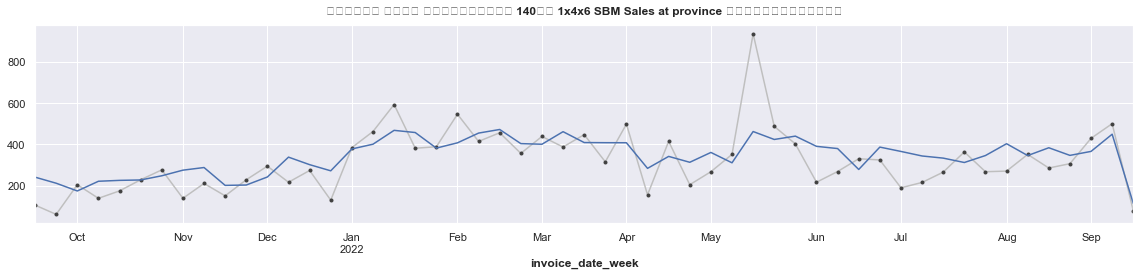

In [230]:
provincename = 'กรุงเทพมหานคร'  
productnameth = 'คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM' 

ax = y.loc(axis=1)[provincename, productnameth].plot(**plot_params, figsize=(16, 4))
ax = y_pred.loc(axis=1)[provincename, productnameth].plot(ax=ax)
ax.set_title(f'{productnameth} Sales at province {provincename}');

## validation

In [231]:
# validation
training_days = (train_end_day - train_start_day).days + 1
validation_days = (val_end_day - val_start_day).days + 1

print('date duration:',(train_end_day - train_start_day).days, "\n")
print("training data set (excluding validation days) has", training_days, "days")
print("validation data set has", validation_days, "days\n")

X_train11_v2 = final_dataset.loc[train_start_day:train_end_day]
X_train11_v2_val = final_dataset.loc[val_start_day:val_end_day]
y_val = y[val_start_day:val_end_day] # use y to evaluate validation set, though we will treat y as unknown when training

model_for_val = BoostedHybrid(model_1=mod_1, model_2=mod_2)

date duration: 343 

training data set (excluding validation days) has 344 days
validation data set has 15 days



In [232]:
#sampling step
val_week = 3

# CHEKCKCKCKCKCK

In [233]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import pickle

# X_1, y, dp = make_X1_features(X_train11, full_train_start_day, full_train_end_day) 
# model.fit1(X_1, y, stack_cols=['provincename', 'productnameth']) 

# X_2 = make_X2_features(X_train11.stack(['provincename','productnameth']), model.y_resid)
# model.fit2(X_2, max_lag, stack_cols=['provincename','productnameth'])

if hybrid_forecasting_type == "direct":
    
    X_1_train, y_train, dp_val = make_X1_features(X_train11_v2, train_start_day, train_end_day) # preparing X1 for hybrid part 1: LinearRegression
    model_for_val.fit1(X_1_train, y_train, stack_cols=['provincename', 'productnameth']) # fit1 before make_X2_features, since X2 may want to create lag features from model.y_resid
    
    X_2_train = make_X2_features(X_train11_v2.stack(['provincename', 'productnameth']), model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    model_for_val.fit2(X_2_train, max_lag, stack_cols=['provincename', 'productnameth'])

    X_1_val = make_X1_features(dp_val.out_of_sample(steps=val_week), val_start_day, val_end_day, is_test_set=True)
    X_2_val = make_X2_features(X_train11_v2_val.stack(['provincename', 'productnameth']), model_for_val.y_resid) # preparing X2 for hybrid part 2: XGBoost
    
    y_fit = model_for_val.predict(X_1_train, X_2_train, max_lag).clip(0.0)
    y_pred = model_for_val.predict(X_1_val, X_2_val, 0).clip(0.0) # set max_lag to 0 because need entire time span for validation data set
    
    if type(model_for_val.model_2) == XGBRegressor:
        pickle.dump(model_for_val.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

<ipython-input-217-1e7991da4ce7>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X2['week_of_year'] = X2.index.weekofyear


this is the final ypred result: invoice_date_week  provincename   productnameth                           
2021-09-19         กรุงเทพมหานคร  BMแป้ง ซากุระ 50ก. (1x8x6)                  -365.014664
                                  BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)          -360.878193
                                  คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24    -383.235840
                                  คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6      -398.852311
                                  คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6      -403.951135
                                                                                 ...     
2022-08-28         จ.สมุทรสาคร    เอ็มเกลือแร่ 250มล เหลือง 1x24               590.045546
                                  เอ็มเกลือแร่ 250มล. ขาว (1x24)               -97.099148
                                  เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)      -141.548609
                                  โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         1809.

In [234]:
y_pred = model_for_val.predict(X_1_val, X_2_val, 0)
y_pred

this is the final ypred result: date        provincename   productnameth                           
2022-09-04  กรุงเทพมหานคร  BMแป้ง ซากุระ 50ก. (1x8x6)                     6.025630
                           BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)            28.757052
                           คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24      57.185685
                           คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6       135.921990
                           คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6        99.014731
                                                                          ...     
2022-09-18  จ.สมุทรสาคร    เอ็มเกลือแร่ 250มล เหลือง 1x24              4681.284393
                           เอ็มเกลือแร่ 250มล. ขาว (1x24)              -416.775294
                           เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)      -926.573854
                           โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         1009.992872
                           โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10     

provincename               กรุงเทพมหานคร                                     \
productnameth BMแป้ง ซากุระ 50ก. (1x8x6) BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)   
date                                                                          
2022-09-04                      6.025630                          28.757052   
2022-09-11                    262.706326                         286.033020   
2022-09-18                   -507.463975                        -472.374708   

provincename                                            \
productnameth คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24   
date                                                     
2022-09-04                                   57.185685   
2022-09-11                                  528.287786   
2022-09-18                                 -466.593675   

provincename                                          \
productnameth คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6   
date                                                   
2022-09-04                                135.921990   
2022-09-11                                610.379926   
2022-09-18                                 82.403533   

provincename                                          \
productnameth คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6   
date                                                   
2022-09-04                                 99.014731   
2022-09-11                                415.624941   
2022-09-18                                121.958539   

provincename                                                \
productnameth คารามูโจ้แผ่นหยัก รสฮ๊อตชิลลี่ 48 กรัม 1x6x4   
date                                                         
2022-09-04                                      846.915625   
2022-09-11                                     1528.264971   
2022-09-18                                      289.436865   

provincename                                                 \
productnameth คารามูโจ้แผ่นเรียบ รสฮ๊อตชิลลี่ 48 กรัม 1x6x4   
date                                                          
2022-09-04                                       488.382437   
2022-09-11                                       521.138293   
2022-09-18                                      1440.894529   

provincename                                            \
productnameth คาลพิส มิกซ์เบอร์รี่ 140มล (แพ็ค8) (1x5)   
date                                                     
2022-09-04                                    6.041957   
2022-09-11                                  262.727215   
2022-09-18                                 -507.438525   

provincename                                           \
productnameth คาลพิส มิกซ์เบอร์รี่ 140มล1x5x6NEWTIEHI   
date                                                    
2022-09-04                                  12.622365   
2022-09-11                                 269.438619   
2022-09-18                                -500.596124   

provincename                                            ...  \
productnameth คาลพิส มิกซ์เบอร์รี่น้ำตาลน้อย140มล1x5x6  ...   
date                                                    ...   
2022-09-04                                    6.509712  ...   
2022-09-11                                  263.227431  ...   
2022-09-18                                 -506.905848  ...   

provincename                          จ.สมุทรสาคร  \
productnameth เอ็ม-150  กระชายดำ BK 100มล. 1x5x10   
date                                                
2022-09-04                             142.064677   
2022-09-11                            -220.860318   
2022-09-18                            1638.524135   

provincename                                       \
productnameth เอ็ม-150  กระชายดำ LT 100มล. 1x5x10   
date                                                
2022-09-04                           -1309.578577   
2022-09-11                           -1189.195888   
2022-09-18                           -1439.215209   

provincename                             

In [235]:
# val_start_day 2022-09-04 00:00:00
# val_end_day 2022-09-18 00:00:00
# date duration: 14 

# test_start_day 2022-09-25 00:00:00
# test_end_day 2022-10-09 00:00:00
# date duration: 14 
dp_val.out_of_sample(steps=3)

,const,trend
2022-09-04,1.0,51.0
2022-09-11,1.0,52.0
2022-09-18,1.0,53.0


In [236]:
X_1_val

,const,trend
date,,
2022-09-04,1.0,51.0
2022-09-11,1.0,52.0
2022-09-18,1.0,53.0


In [237]:
X_2_val

,provincename,productnameth,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,baseqty,...,day_of_week,month,quarter,week_of_year,day,y_res_lag_1,y_res_lag_2,y_mean_rolling_5,y_median_rolling_10,y_median_rolling_15
invoice_date_week,,,,,,,,,,,,,,,,,,,,,
2022-09-04,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.423529,0.386651,0.349772,0.257575,0.165378
2022-09-04,0,1,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0,...,0,0,0,0,0,-32.880000,-26.321633,-11.363265,-19.133878,-16.413061
2022-09-04,0,2,48.0,52.0,0.0,12.0,44.0,48.0,52.0,256.0,...,0,0,0,0,0,78.962353,86.061849,65.361345,0.609076,-23.843697
2022-09-04,0,3,6.0,0.0,0.0,12.0,78.0,6.0,12.0,114.0,...,0,0,0,0,0,-87.774118,-5.340888,-65.707659,-57.107971,-16.607971
2022-09-04,0,4,0.0,18.0,0.0,18.0,6.0,6.0,0.0,48.0,...,0,0,0,0,0,-100.752941,-37.460984,-91.969028,-70.293157,-37.460984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-18,5,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN
2022-09-18,5,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN
2022-09-18,5,91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN


In [238]:
from math import sqrt
rmsle_train = sqrt(mean_squared_error(y_train.iloc[max_lag:,:].clip(0.0), y_fit)) 
rmsle_valid = sqrt(mean_squared_error(y_val.clip(0.0), y_pred) )
print()
print(f'Training RMSE: {rmsle_train:.10f}')
print(f'Validation RMSE: {rmsle_valid:.10f}')
    
y_predict = y_pred.stack(['provincename', 'productnameth']).reset_index()
y_target = y_val.stack(['provincename', 'productnameth']).reset_index().copy()
y_target.rename(columns={y_target.columns[3]:'baseqty'},inplace=True)
y_target['baseqty_pred'] = y_predict[0].clip(0.0)

print('\nValidation RMSE by productnameth')
display(y_target.groupby('productnameth').apply(lambda r: sqrt(mean_squared_error(r['baseqty'], r['baseqty_pred']))))

print('\nValidation RMSE by provincename')
display(y_target.sort_values(by="provincename").groupby('provincename').apply(lambda r: sqrt(mean_squared_error(r['baseqty'], r['baseqty_pred']))))


Training RMSE: 28968.3670030549
Validation RMSE: 21107.9050187167

Validation RMSE by productnameth


productnameth
BMแป้ง ซากุระ 50ก. (1x8x6)                   122.238609
BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)           117.540718
คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24     132.013963
คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6       146.900368
คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6       143.342517
                                               ...     
เอ็มเกลือแร่ 250มล. ขาว (1x24)                 0.000000
เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)         0.000000
โสม อิน-ซัม น้ำตาลน้อย 100 มล. (1x5x10)        0.000000
โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         1323.532636
โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10       514.847758
Length: 95, dtype: float64


Validation RMSE by provincename


provincename
กรุงเทพมหานคร    18632.912016
จ.นครนายก          661.161545
จ.นนทบุรี         6652.427123
จ.ปทุมธานี        7550.566142
จ.สมุทรปราการ     5977.359924
จ.สมุทรสาคร       4295.561150
dtype: float64

## Forecast

In [239]:
final_dataset

baseqty  \
provincename                               กรุงเทพมหานคร   
productnameth     คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   
invoice_date_week                                          
2021-09-19                                         105.0   
2021-09-26                                          60.0   
2021-10-03                                         204.0   
2021-10-10                                         138.0   
2021-10-17                                         174.0   
2021-10-24                                         228.0   
2021-10-31                                         276.0   
2021-11-07                                         138.0   
2021-11-14                                         210.0   
2021-11-21                                         150.0   
2021-11-28                                         228.0   
2021-12-05                                         294.0   
2021-12-12                                         216.0   
2021-12-19                                         273.0   
2021-12-26                                         129.0   
2022-01-02                                         384.0   
2022-01-09                                         462.0   
2022-01-16                                         593.0   
2022-01-23                                         381.0   
2022-01-30                                         388.0   
2022-02-06                                         546.0   
2022-02-13                                         414.0   
2022-02-20                                         456.0   
2022-02-27                                         356.0   
2022-03-06                                         438.0   
2022-03-13                                         387.0   
2022-03-20                                         447.0   
2022-03-27                                         315.0   
2022-04-03                                         498.0   
2022-04-10                                         155.0   
2022-04-17                                         414.0   
2022-04-24                                         204.0   
2022-05-01                                         267.0   
2022-05-08                                         351.0   
2022-05-15                                         936.0   
2022-05-22                                         487.0   
2022-05-29                                         402.0   
2022-06-05                                         216.0   
2022-06-12                                         268.0   
2022-06-19                                         330.0   
2022-06-26                                         324.0   
2022-07-03                                         189.0   
2022-07-10                                         215.0   
2022-07-17                                         265.0   
2022-07-24                                         363.0   
2022-07-31                                         267.0   
2022-08-07                                         270.0   
2022-08-14                                         351.0   
2022-08-21                                         285.0   
2022-08-28                                         306.0   
2022-09-04                                         429.0   
2022-09-11                                         500.0   
2022-09-18                                          78.0   
2022-09-25                                           0.0   
2022-10-02                                           0.0   
2022-10-09                                           0.0   

                                                         \
provincename                                              
productnameth     คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date_week                                         
2021-09-19                                        472.0   
2021-09-26                                        256.0   
2021-10-03                                        512.0   
2021-10-10                         

In [240]:
# train/test split prep that is the same for any of the hybrid forecasting methods
train_days = (full_train_end_day - full_train_start_day).days + 1
test_days = (test_end_day - test_start_day).days + 1

print("data trained over", train_days, "days")
print("test forecasting period is", test_days, "days through", test_end_day, "\n")
store_sales_in_date_range = final_dataset.copy()

data trained over 365 days
test forecasting period is 15 days through 2022-10-09 00:00:00 



In [241]:
store_data_in_test_range = final_dataset.loc[test_start_day:test_end_day]
model_for_test = BoostedHybrid(model_1=mod_1, model_2=mod_2)

In [242]:
dp.out_of_sample(steps=3)

,const,trend
2022-09-25,1.0,54.0
2022-10-02,1.0,55.0
2022-10-09,1.0,56.0


In [243]:
if hybrid_forecasting_type == "direct":
    X_1_test = make_X1_features(dp.out_of_sample(steps=3), test_start_day, test_end_day, is_test_set=True)
    X_2_test = make_X2_features(store_data_in_test_range.loc[test_start_day:test_end_day]
                                .stack(['provincename', 'productnameth']),
                                model.y_resid) # preparing X2 for hybrid part 2: XGBoost
    
    y_forecast = pd.DataFrame(model.predict(X_1_test, X_2_test, 0).clip(0.0), index=X_1_test.index, columns=y.columns) # set max_lag to 0 because need entire time span for test data set
    
    if type(model.model_2) == XGBRegressor:
        pickle.dump(model.model_2, open("xgb_temp.pkl", "wb"))
        m2 = pickle.load(open("xgb_temp.pkl", "rb"))
        print("XGBRegressor paramaters:\n",m2.get_xgb_params(), "\n")

this is the final ypred result: date        provincename   productnameth                           
2022-09-25  กรุงเทพมหานคร  BMแป้ง ซากุระ 50ก. (1x8x6)                     5.914994
                           BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)            30.432154
                           คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24      64.597202
                           คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6        71.476868
                           คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6       111.890602
                                                                          ...     
2022-10-09  จ.สมุทรสาคร    เอ็มเกลือแร่ 250มล เหลือง 1x24              4968.481416
                           เอ็มเกลือแร่ 250มล. ขาว (1x24)              -468.536783
                           เอ็มเกลือแร่ พลัส 250มล. เหลือง (1x24)     -1078.251549
                           โสมอินซัม น้ำตาล 6% 100 มล.(1x5x10)         1257.401928
                           โสมอินซัม พลัสเห็ดหลินจือ 100มล 1x5x10     

<ipython-input-217-1e7991da4ce7>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X2['week_of_year'] = X2.index.weekofyear


In [244]:
X_1_test.shape

(3, 2)

/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3655 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/homebrew/Caskroom/miniforge/base/envs/py39t/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3585 missing from current fon

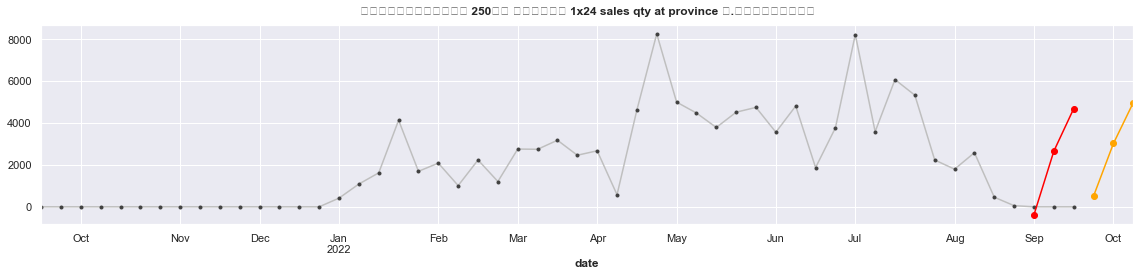

In [245]:
provincename = 'จ.สมุทรสาคร'  
productnameth = 'เอ็มเกลือแร่ 250มล เหลือง 1x24'

ax = y.loc(axis=1)[provincename, productnameth].plot(**plot_params, figsize=(16, 4))
ax = y_pred.loc(axis=1)[provincename, productnameth].plot(ax=ax, marker='.', color='red', markersize=12)
ax = y_forecast.loc(axis=1)[provincename, productnameth].plot(ax=ax, marker='.', color='orange', markersize=12)
ax.set_title(f'{productnameth} sales qty at province {provincename}');

In [246]:
y

provincename                               กรุงเทพมหานคร  \
productnameth     คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   
invoice_date_week                                          
2021-09-19                                         105.0   
2021-09-26                                          60.0   
2021-10-03                                         204.0   
2021-10-10                                         138.0   
2021-10-17                                         174.0   
2021-10-24                                         228.0   
2021-10-31                                         276.0   
2021-11-07                                         138.0   
2021-11-14                                         210.0   
2021-11-21                                         150.0   
2021-11-28                                         228.0   
2021-12-05                                         294.0   
2021-12-12                                         216.0   
2021-12-19                                         273.0   
2021-12-26                                         129.0   
2022-01-02                                         384.0   
2022-01-09                                         462.0   
2022-01-16                                         593.0   
2022-01-23                                         381.0   
2022-01-30                                         388.0   
2022-02-06                                         546.0   
2022-02-13                                         414.0   
2022-02-20                                         456.0   
2022-02-27                                         356.0   
2022-03-06                                         438.0   
2022-03-13                                         387.0   
2022-03-20                                         447.0   
2022-03-27                                         315.0   
2022-04-03                                         498.0   
2022-04-10                                         155.0   
2022-04-17                                         414.0   
2022-04-24                                         204.0   
2022-05-01                                         267.0   
2022-05-08                                         351.0   
2022-05-15                                         936.0   
2022-05-22                                         487.0   
2022-05-29                                         402.0   
2022-06-05                                         216.0   
2022-06-12                                         268.0   
2022-06-19                                         330.0   
2022-06-26                                         324.0   
2022-07-03                                         189.0   
2022-07-10                                         215.0   
2022-07-17                                         265.0   
2022-07-24                                         363.0   
2022-07-31                                         267.0   
2022-08-07                                         270.0   
2022-08-14                                         351.0   
2022-08-21                                         285.0   
2022-08-28                                         306.0   
2022-09-04                                         429.0   
2022-09-11                                         500.0   
2022-09-18                                          78.0   

provincename                                             \
productnameth     คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
invoice_date_week                                         
2021-09-19                                        472.0   
2021-09-26                                        256.0   
2021-10-03                                        512.0   
2021-10-10                                        352.0   
2021-10-17                                        400.0   
2021-10-24                                        352.0   
2021-10-31                                        383.0   
2021-11-07                                       

In [247]:
y_pred

provincename               กรุงเทพมหานคร                                     \
productnameth BMแป้ง ซากุระ 50ก. (1x8x6) BMแป้ง สวีทตี้พิงค์50ก.ใหม่(1x8x6)   
date                                                                          
2022-09-04                      6.025630                          28.757052   
2022-09-11                    262.706326                         286.033020   
2022-09-18                   -507.463975                        -472.374708   

provincename                                            \
productnameth คารามูโจ้สตรองหยักฮอตชิลลี่ 44 กรัม 1x24   
date                                                     
2022-09-04                                   57.185685   
2022-09-11                                  528.287786   
2022-09-18                                 -466.593675   

provincename                                          \
productnameth คารามูโจ้หยัก ฮ๊อตชิลลี่ 18 กรัม 1x6x6   
date                                                   
2022-09-04                                135.921990   
2022-09-11                                610.379926   
2022-09-18                                 82.403533   

provincename                                          \
productnameth คารามูโจ้เรียบ ฮอตชิลลี่ 18 กรัม 1x6x6   
date                                                   
2022-09-04                                 99.014731   
2022-09-11                                415.624941   
2022-09-18                                121.958539   

provincename                                                \
productnameth คารามูโจ้แผ่นหยัก รสฮ๊อตชิลลี่ 48 กรัม 1x6x4   
date                                                         
2022-09-04                                      846.915625   
2022-09-11                                     1528.264971   
2022-09-18                                      289.436865   

provincename                                                 \
productnameth คารามูโจ้แผ่นเรียบ รสฮ๊อตชิลลี่ 48 กรัม 1x6x4   
date                                                          
2022-09-04                                       488.382437   
2022-09-11                                       521.138293   
2022-09-18                                      1440.894529   

provincename                                            \
productnameth คาลพิส มิกซ์เบอร์รี่ 140มล (แพ็ค8) (1x5)   
date                                                     
2022-09-04                                    6.041957   
2022-09-11                                  262.727215   
2022-09-18                                 -507.438525   

provincename                                           \
productnameth คาลพิส มิกซ์เบอร์รี่ 140มล1x5x6NEWTIEHI   
date                                                    
2022-09-04                                  12.622365   
2022-09-11                                 269.438619   
2022-09-18                                -500.596124   

provincename                                            ...  \
productnameth คาลพิส มิกซ์เบอร์รี่น้ำตาลน้อย140มล1x5x6  ...   
date                                                    ...   
2022-09-04                                    6.509712  ...   
2022-09-11                                  263.227431  ...   
2022-09-18                                 -506.905848  ...   

provincename                          จ.สมุทรสาคร  \
productnameth เอ็ม-150  กระชายดำ BK 100มล. 1x5x10   
date                                                
2022-09-04                             142.064677   
2022-09-11                            -220.860318   
2022-09-18                            1638.524135   

provincename                                       \
productnameth เอ็ม-150  กระชายดำ LT 100มล. 1x5x10   
date                                                
2022-09-04                           -1309.578577   
2022-09-11                           -1189.195888   
2022-09-18                           -1439.215209   

provincename                             

In [248]:
y_forecast

provincename                           กรุงเทพมหานคร  \
productnameth คาลพิส มินิ มิกซ์เบอร์ 140มล 1x4x6 SBM   
date                                                   
2022-09-25                                184.005740   
2022-10-02                                266.720608   
2022-10-09                                  0.000000   

provincename                                         \
productnameth คาลพิส มินิ มิกซ์เบอร์รี่ 140มล 1X4X8   
date                                                  
2022-09-25                                 0.000000   
2022-10-02                               190.771037   
2022-10-09                                 0.000000   

provincename                                         \
productnameth คาลพิส มินิ ออริจินัล 140มล 1x4x6 SBM   
date                                                  
2022-09-25                                 0.000000   
2022-10-02                               342.184041   
2022-10-09                                 0.000000   

provincename                                     \
productnameth คาลพิส ออริจินัล 300 มล. 1x24 SBM   
date                                              
2022-09-25                            27.455635   
2022-10-02                           284.414533   
2022-10-09                             0.000000   

provincename                                      \
productnameth คาลพิส ออริจินัล 300 มล. 1x4x6 SBM   
date                                               
2022-09-25                             217.55425   
2022-10-02                             335.60248   
2022-10-09                               0.00000   

provincename                                          \
productnameth คาลพิส ออริจินัล โปรโมชั่น 300มล 1X4X6   
date                                                   
2022-09-25                                  0.000000   
2022-10-02                                226.501332   
2022-10-09                                  0.000000   

provincename                                            \
productnameth คาลพิส แลคโตะ มินิ ออริจินัล 140มล 1X4X8   
date                                                     
2022-09-25                                         0.0   
2022-10-02                                         0.0   
2022-10-09                                         0.0   

provincename                                       \
productnameth คาลพิส โซดา ยูสุ ฮันนี่ 245มล 1X4X6   
date                                                
2022-09-25                              76.138128   
2022-10-02                             428.582697   
2022-10-09                              44.379194   

provincename                                         \
productnameth คาลพิส โซดา องุ่นเคียวโฮ 245 มล 1x4x6   
date                                                  
2022-09-25                               120.278231   
2022-10-02                                 0.000000   
2022-10-09                               376.511295   

provincename                                            ...  \
productnameth คาลพิส โซดาออริจินัลน้ำตาลน้อย245มล1X4X6  ...   
date                                                    ...   
2022-09-25                                  534.182394  ...   
2022-10-02                                  510.823167  ...   
2022-10-09                                 1218.281811  ...   

provincename                         จ.สมุทรสาคร  \
productnameth ลิโพ-ไฟน์ ราฟเฟิล2022 100มล 1X5X10   
date                                               
2022-09-25                            176.585021   
2022-10-02                              0.000000   
2022-10-09                              0.000000   

provincename                                      \
productnameth เปปทีน4000 BT 100ML 1x4x6 INNER BL   
date                                               
2022-09-25                             72.518292   
2022-10-02                              0.000000   
2022-10-09                              0.000000   

provincename                            

# LSTM (kernel dies)

In [249]:
# X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_valid_series = X_validation.values.reshape((X_validation.shape[0], X_validation.shape[1], 1))

In [250]:
# from keras import optimizers
# lr = 0.0003
# epochs = 10
# batch = 10
# adam = optimizers.Adam(lr)

In [251]:
# model_lstm = Sequential()
# model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
# model_lstm.add(Dense(1))
# model_lstm.compile(loss='mse', optimizer=adam)
# model_lstm.summary()

In [252]:
# lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_validation), epochs=epochs, verbose=2)

In [253]:
# weekly (index)
# public holiday
# bangkok
# linear regression